In [21]:
#Needs NLP_Data_Preprocessor to have been run before at least once
#Needs newest Pandas and Numpy, or else a bug in the libraries leads to an error... (state 16.06.2022)

import sqlite3
import matplotlib
import pandas as pd
import io
import numpy as np
import spacy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm, naive_bayes
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from collections import Counter

In [2]:

def adapt_array(arr):
    """
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)


# Converts np.array to TEXT when inserting
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)


nlp = spacy.load("de_core_news_md")
cnx = sqlite3.connect("corpus_NLP_preprocessed", detect_types=sqlite3.PARSE_DECLTYPES)


In [3]:
# Eventuell notwendige, einmalige Installation der Spacy-Pipeline:
# !python -m spacy download de_core_news_lg

In [4]:
# comments_df = pd.read_sql_query("Select ID_Post, Headline, Body FROM Posts",cnx)
# labels_df = pd.read_sql_query("SELECT * From Annotations_consolidated",cnx)


In [5]:
labels = ["ArgumentsUsed","Discriminating","Inappropriate","OffTopic","PersonalStories","PossiblyFeedback","SentimentNegative","SentimentNeutral","SentimentPositive"]

label_map = {y:x for (x,y) in enumerate(labels)}


In [19]:
def getLabeledPartPreprocessed(label):
    """

    :param label: Das Label, so dass wir alle Posts auswählen, bei denen dieses Label gesetzt ist
    :return: Ein DataFrame 301 Spalten. Die ersten 300 sind von den Wort-Embedding, die 301. ist das Value.
    """
    original = pd.read_sql_query("SELECT Text_Array,Value "
                                    "FROM {} "
                                    .format(label),cnx)
    # Kann einfach um weitere Spalten mittels des column stacks erweitert werden

    inter = np.array(original[["Text_Array"]].values.tolist())
    inter = inter.reshape(inter.shape[0],inter.shape[3])
    return np.column_stack((original[["Value"]],inter))


def getLabeledPartPreprocessedDetailed(label):
    """

    :param label: Das Label, so dass wir alle Posts auswählen, bei denen dieses Label gesetzt ist
    :return: Ein DataFrame 304 Spalten. Die ersten ist das Value, danach 300 Spalten Wort-Embedding, und danach
             Status des Posts (1 -> online, 0 -> deleted), PositiveVotes und NegativesVote (beide durch Anzahl Votes geteilt, falls nicht 0)
    """
    original = pd.read_sql_query("SELECT Text_Array,Value, Status,PositiveVotes,NegativeVotes "
                                 "FROM {} INNER JOIN Posts Using(ID_Post) "
                                 .format(label),cnx)
    # Kann einfach um weitere Spalten mittels des column stacks erweitert werden

    for index,row in original.iterrows():
        original.loc[index,"Status"] =  1 if row["Status"] == "online" else 0
        sum = original.loc[index,"PositiveVotes"] + original.loc[index,"NegativeVotes"]
        if sum != 0:
            original.loc[index,"PositiveVotes"] =  original.loc[index,"PositiveVotes"]/sum
            original.loc[index,"NegativeVotes"] =  original.loc[index,"NegativeVotes"]/sum


    inter = np.array(original[["Text_Array"]].values.tolist())
    inter = inter.reshape(inter.shape[0],inter.shape[3])
    return np.column_stack((original[["Value"]].to_numpy(dtype=float),
                            inter,
                            original[["Status"]].to_numpy(dtype=float),
                            original[["PositiveVotes"]].to_numpy(dtype=float),
                            original[["NegativeVotes"]].to_numpy(dtype=float)))


In [7]:
getLabeledPartPreprocessedDetailed(labels[0])
# inter = np.array(original[["Text_Array"]].values.tolist())
# inter = inter.reshape(inter.shape[0],inter.shape[3])
# np.column_stack((inter,original[["Value"]]))[:,0:301]

array([[ 0.00000000e+00,  8.68638575e-01, -1.26829433e+00, ...,
         1.00000000e+00,  2.50000000e-01,  7.50000000e-01],
       [ 1.00000000e+00,  2.59616828e+00, -4.56688017e-01, ...,
         1.00000000e+00,  6.66666667e-01,  3.33333333e-01],
       [ 1.00000000e+00,  1.26443768e+00, -7.37381876e-02, ...,
         1.00000000e+00,  8.75000000e-01,  1.25000000e-01],
       ...,
       [ 1.00000000e+00,  1.14167368e+00, -1.75747648e-03, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.55016494e+00, -7.77563989e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.24676728e+00, -1.22532809e+00, ...,
         1.00000000e+00,  6.25000000e-01,  3.75000000e-01]])

In [139]:
# simplefilter("ignore", category=ConvergenceWarning)

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



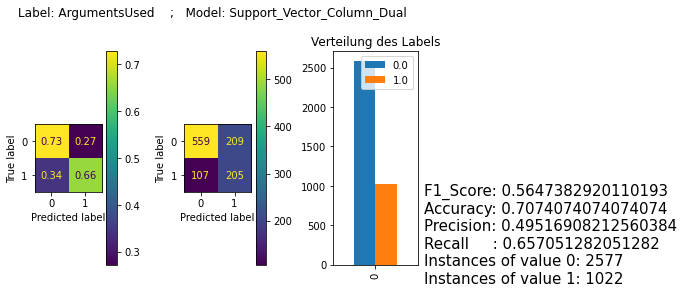

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



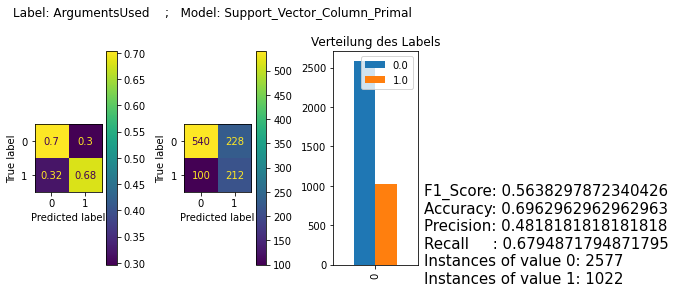

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



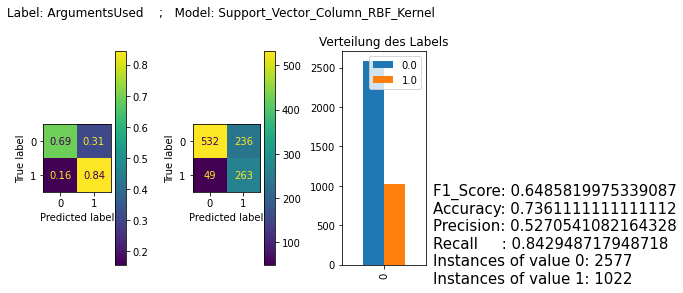

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



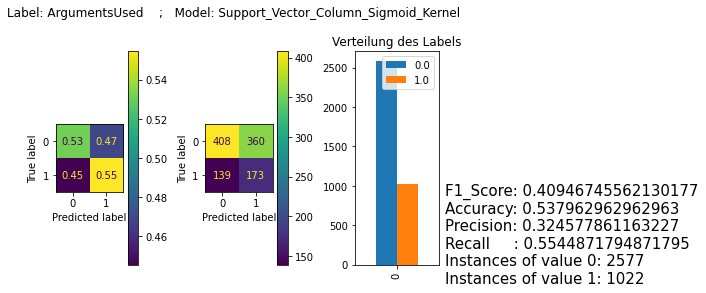

--------------
--------------
--------------
Label:    ArgumentsUsed
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



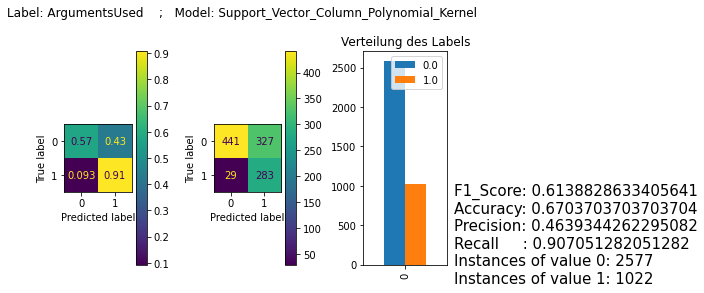

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



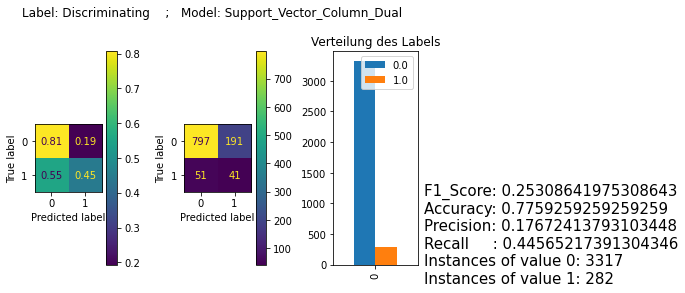

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



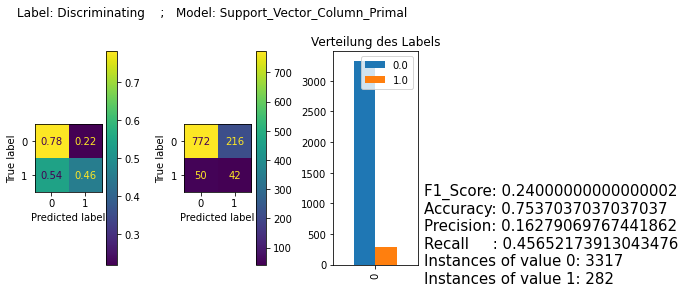

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



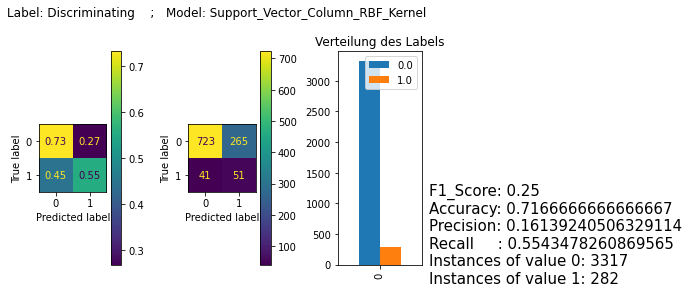

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



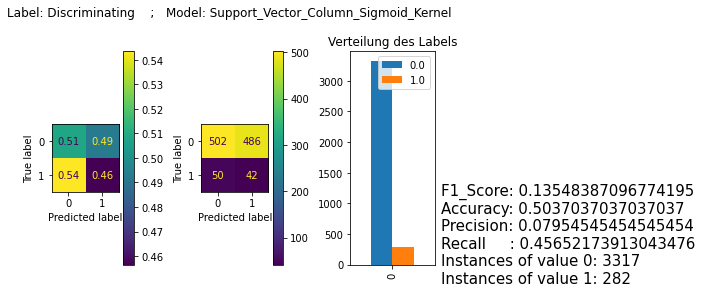

--------------
--------------
--------------
Label:    Discriminating
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



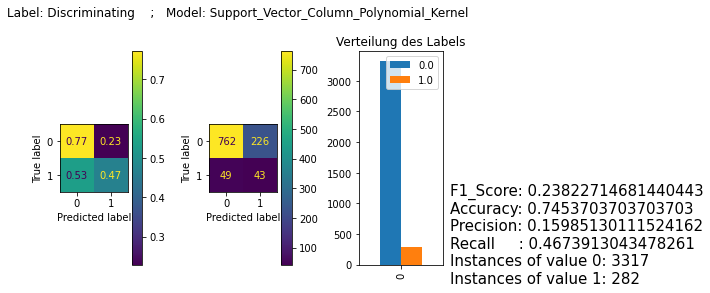

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



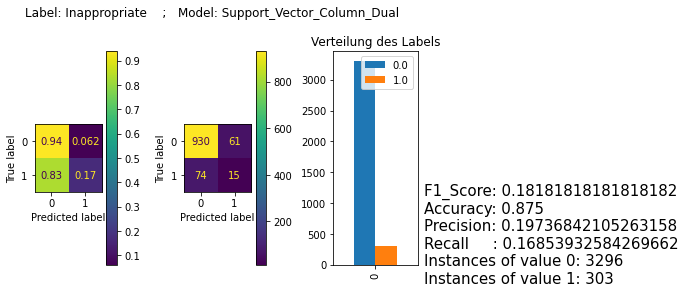

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



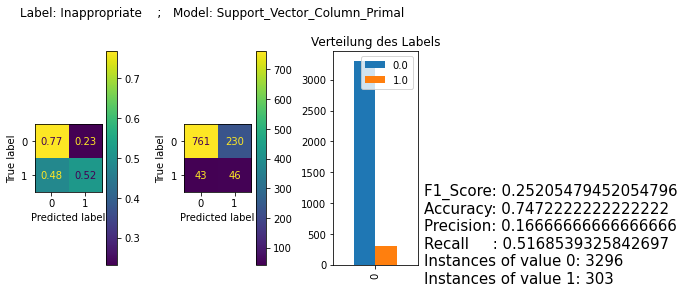

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



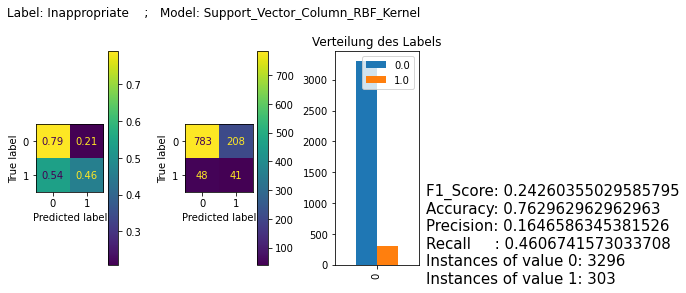

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



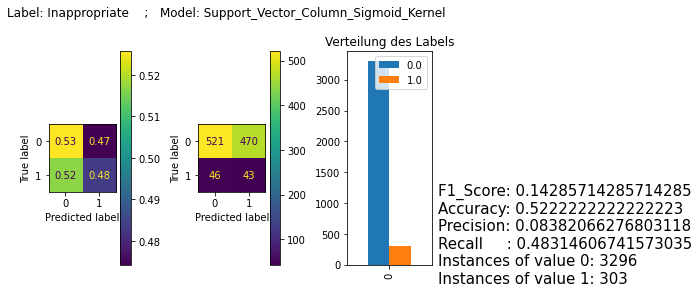

--------------
--------------
--------------
Label:    Inappropriate
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



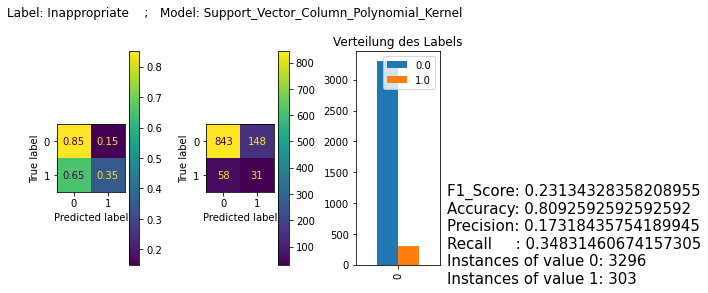

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



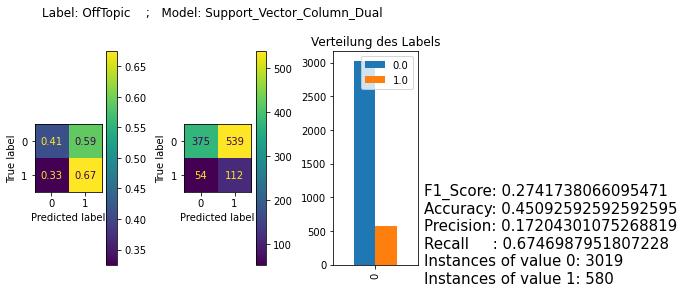

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



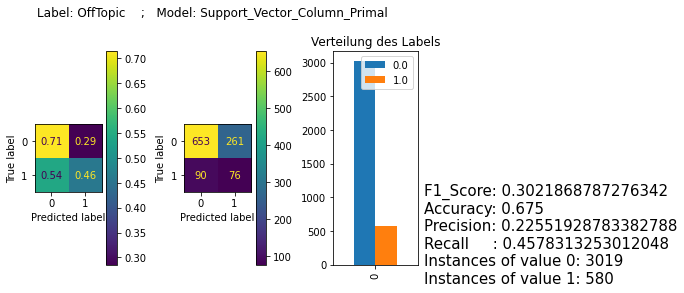

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



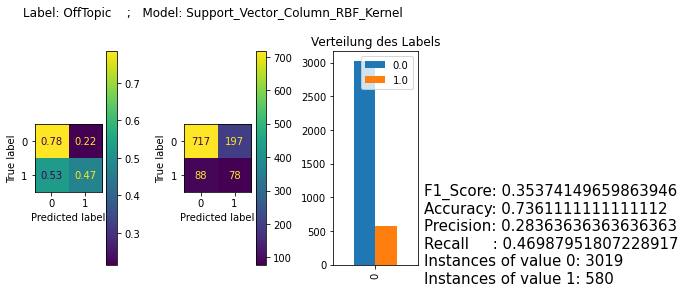

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



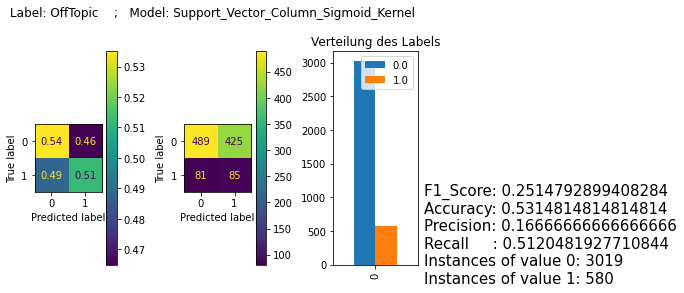

--------------
--------------
--------------
Label:    OffTopic
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



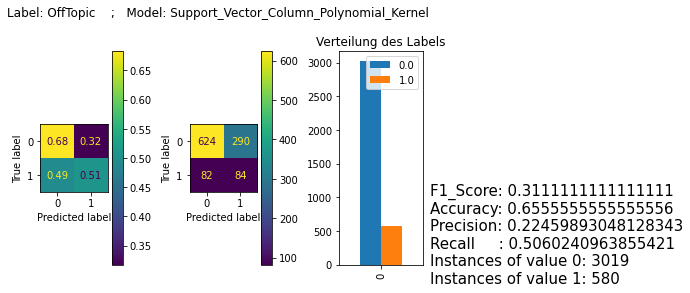

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



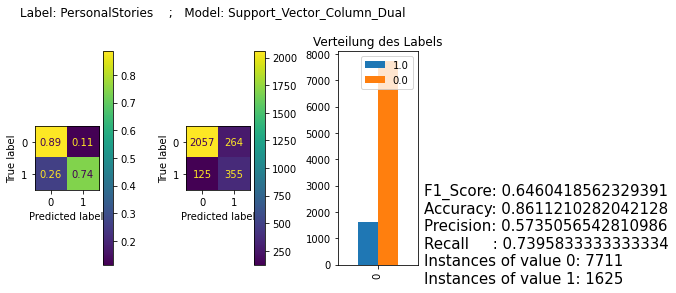

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



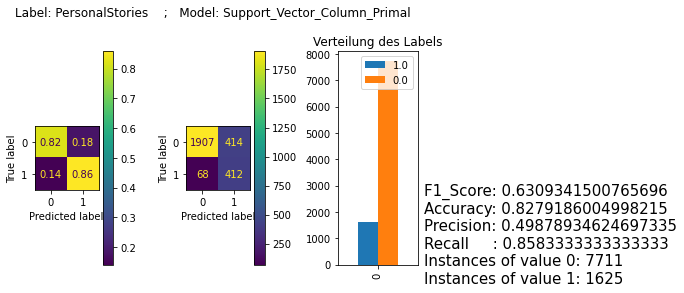

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



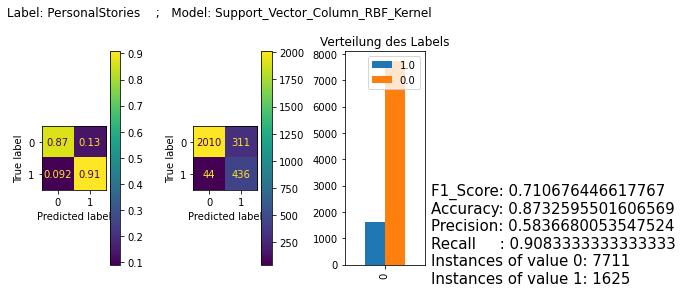

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



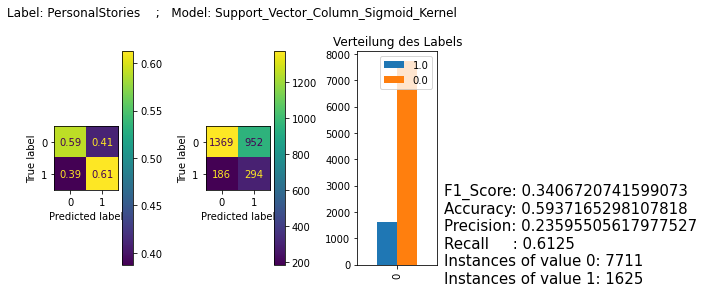

--------------
--------------
--------------
Label:    PersonalStories
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



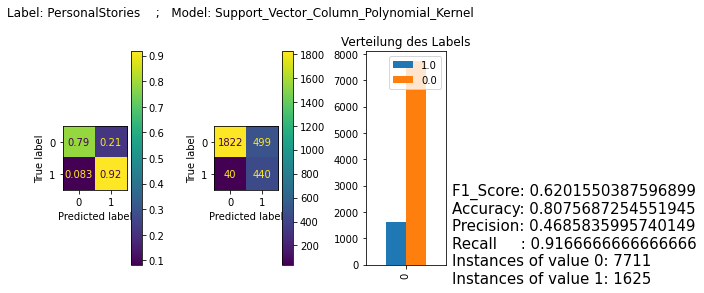

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



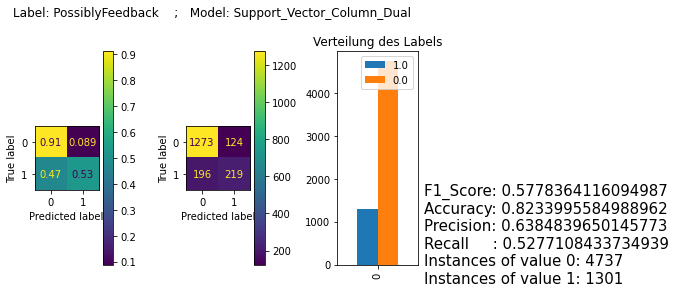

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



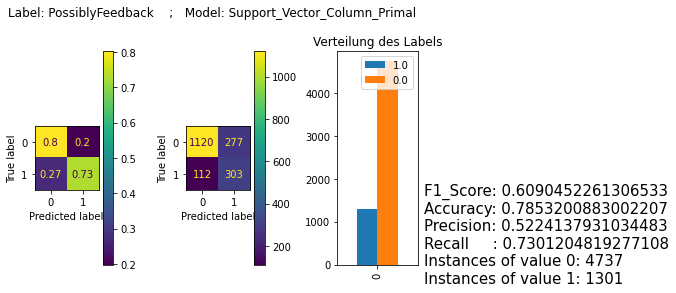

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



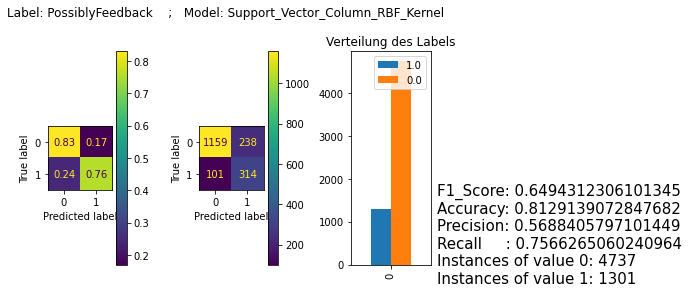

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



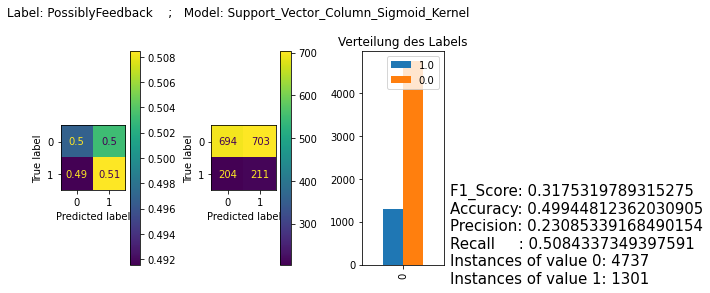

--------------
--------------
--------------
Label:    PossiblyFeedback
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



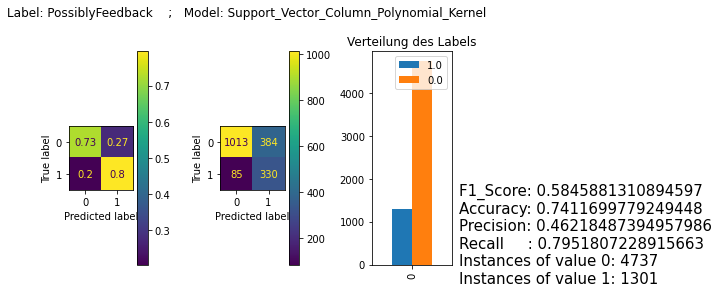

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



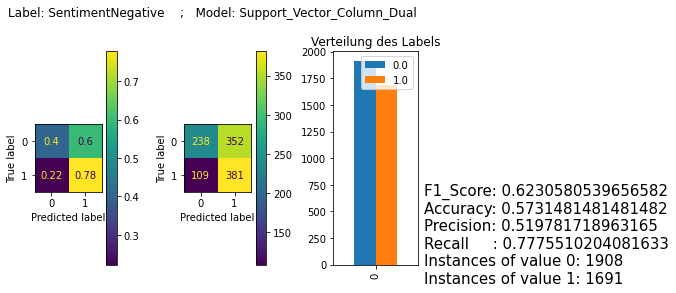

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



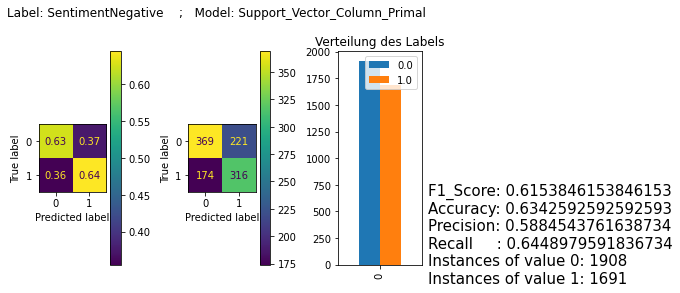

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



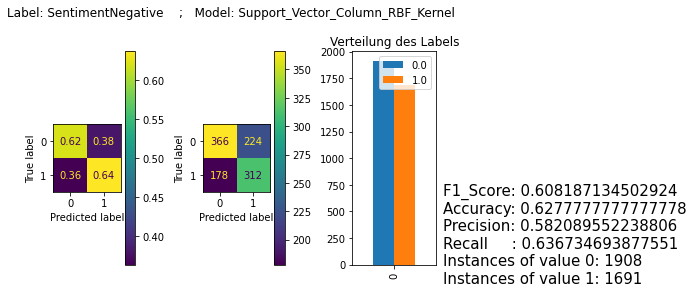

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



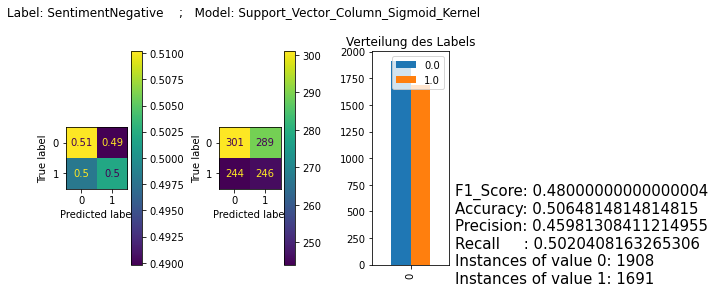

--------------
--------------
--------------
Label:    SentimentNegative
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



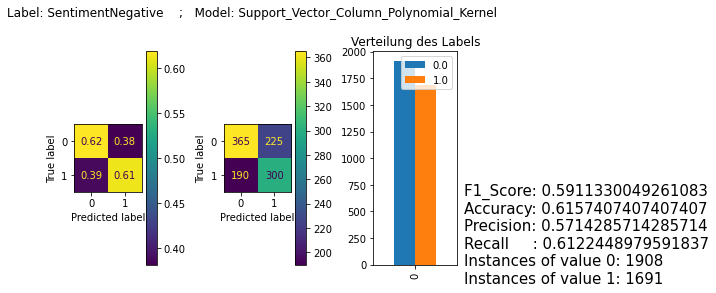

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



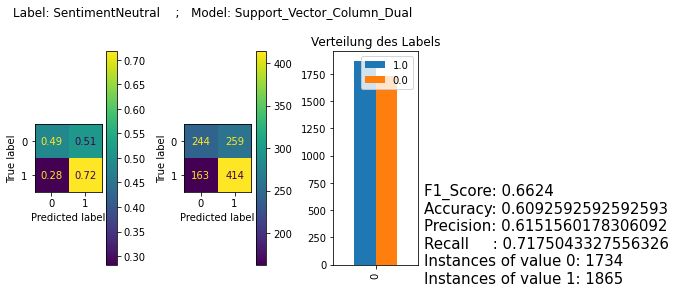

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



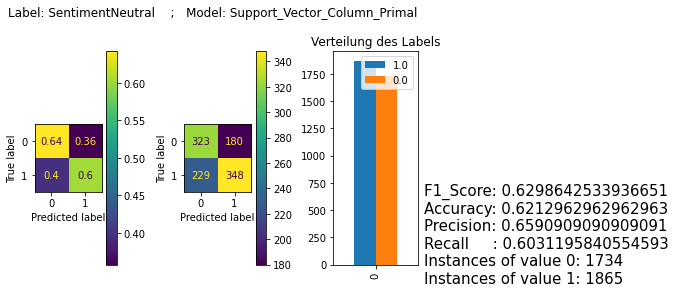

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



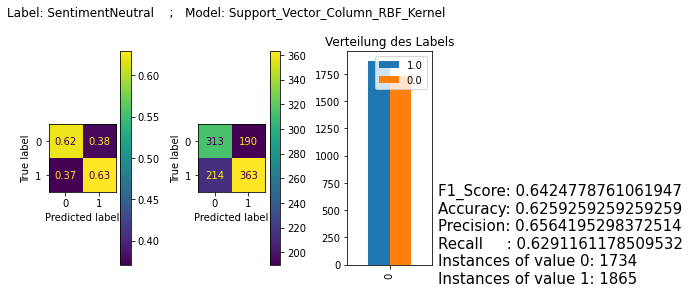

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



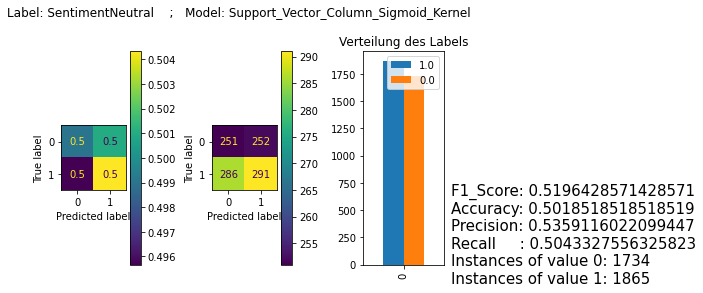

--------------
--------------
--------------
Label:    SentimentNeutral
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



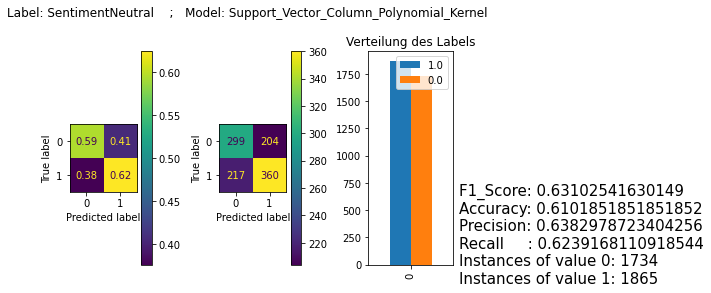

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Dual:
Confusion Matrix: 



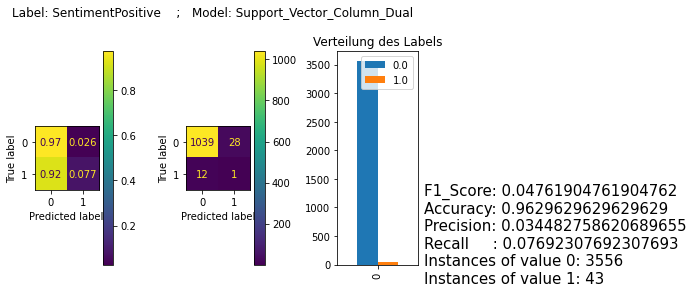

--------------


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Primal:
Confusion Matrix: 



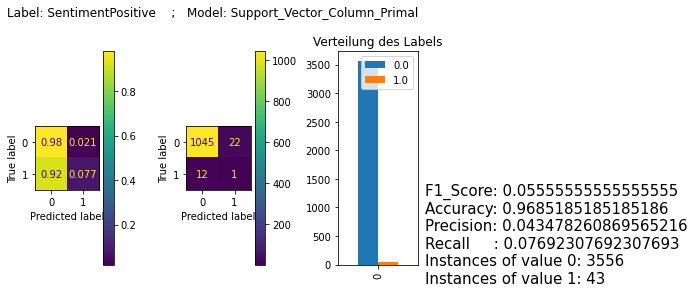

--------------
--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_RBF_Kernel:
Confusion Matrix: 



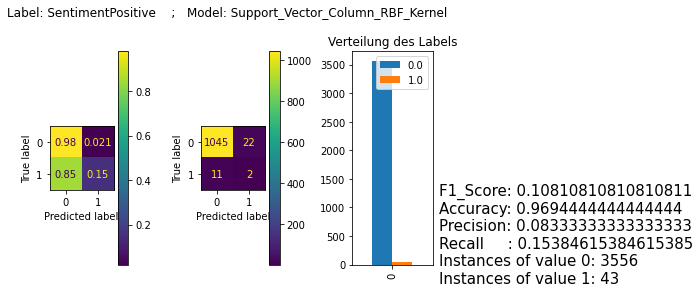

--------------
--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Sigmoid_Kernel:
Confusion Matrix: 



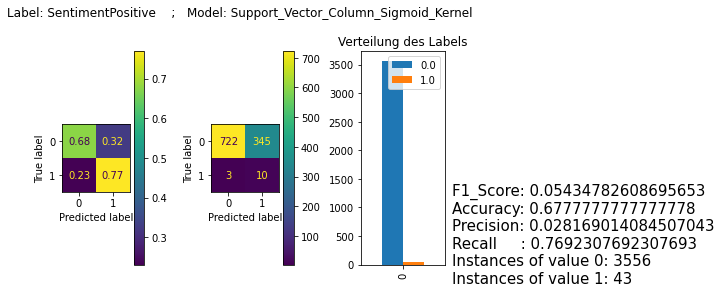

--------------
--------------
--------------
Label:    SentimentPositive
--------------
Support_Vector_Column_Polynomial_Kernel:
Confusion Matrix: 



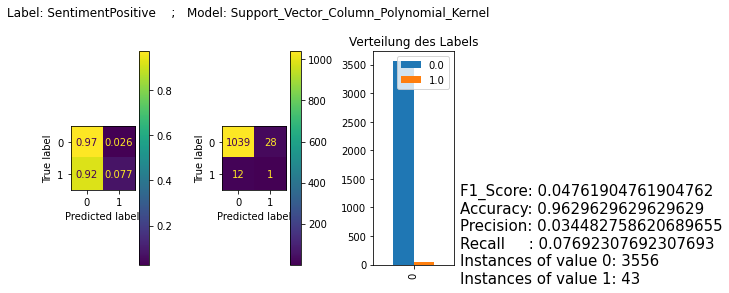

--------------


In [25]:

# Versuch 1:
# Lernen jedes Labels als binäres Label.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.
for label in labels:
    # Table_Join holen:
    joined_table = getLabeledPartPreprocessedDetailed(label)

    #Splitten in Test & Trainingsdatensätze:
    text_train, text_test, label_train, label_test = train_test_split(joined_table[:,1:],joined_table[:,0],
                                                                          test_size=0.3,
                                                                          random_state=1234, shuffle=True)
    label_test = np.array(label_test,dtype=int)
    label_train = np.array(label_train,dtype=int)
    # # Text zu Wort-Vektoren umwandeln:
    # text_train = text_train.apply(lambda x: nlp(x).vector)
    # text_test  = text_test.apply(lambda x: nlp(x).vector)
    #
    # #Handling mapping irregularities:
    # for index, element in enumerate(text_train):
    #     if (element.shape != (300,)):
    #         print(index, element.shape)
    #         text_train.iat[index]= text_train.iat[index].reshape((300,))
    #
    # for index, element in enumerate(text_test):
    #     if (element.shape != (300,)):
    #         print(index, element.shape)
    #         text_test.iat[index]= text_test.iat[index].reshape((300,))
    #
    # #Umwandeln in numpy-Matrizen:
    # text_train= np.column_stack(text_train)
    # text_test = np.column_stack(text_test)

    model_names = ["Support_Vector_Column_Dual","Support_Vector_Column_Primal","Support_Vector_Column_RBF_Kernel","Support_Vector_Column_Sigmoid_Kernel","Support_Vector_Column_Polynomial_Kernel"]
    models = [svm.LinearSVC(class_weight = "balanced"),
              svm.LinearSVC(dual= False,class_weight = "balanced"),
              svm.SVC(class_weight = "balanced"),
              svm.SVC(kernel="sigmoid",class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=3,class_weight = "balanced")]
    # model_names = ["Support_Vector_Column", "Naive Gaussian Bayes", "Multi_Layer_Perceptron"]
    # models = [svm.LinearSVC(),naive_bayes.GaussianNB(), MLPClassifier()]
    for model,model_name in zip(models,model_names):
        # Transposed the matrices in the input because calculating text_train takes so long, and I didn't want to recalculate it.

        #Trainieren des Modells:
        model.fit(text_train,label_train)

        #Vom trainierten Modell geschätzte Labels des Testdatensatzes:
        model_predictions = model.predict(text_test)

        # Verteilung der Instanzen auf das Label (d.h. wie viele 0-Instanzen und wie viele 1-Instanzen gibt es)
        counts_dict = Counter(joined_table[:,0])
        val_counts = pd.DataFrame({x:[counts_dict[x]] for x in (counts_dict)})

        print("--------------")
        print("--------------")
        print("Label:    {}".format(label))


        print("--------------")
        print("{}:".format(model_name))

        print("Confusion Matrix: \n")
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
        fig.suptitle(("Label: {}    ;   Model: {}".format(label,model_name)))
        classifier_evaluation = ("F1_Score: "+  str(sklearn.metrics.f1_score       (label_test, model_predictions))+ "\n"+
                                "Accuracy: "+  str(sklearn.metrics.accuracy_score (label_test, model_predictions))+ "\n"+
                                "Precision: "+ str(sklearn.metrics.precision_score(label_test, model_predictions))+ "\n"+
                                "Recall     : "+    str(sklearn.metrics.recall_score   (label_test, model_predictions))+ "\n"+
                                "Instances of value 0: "+str(int(val_counts[0])) +"\n"+ "Instances of value 1: "+str(int(val_counts[1])))
        # ax1.annotate( classifier_evaluation, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize = 18)
        #Alternative Variante
        plt.figtext(0.99, 0.01, classifier_evaluation, horizontalalignment='left', verticalalignment ="bottom", fontsize = 15)
        conf_matrix_normalized = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions, normalize="true",ax= ax1)
        conf_matrix = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions,ax= ax2)
        bar_plot = val_counts.plot.bar(ax = ax3,title = "Verteilung des Labels")
        fig.tight_layout()
        plt.show()


        print("--------------")




C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    ArgumentsUsed
Support_Vector_Column_Dual:
--------------
--------------
Label:    ArgumentsUsed
Support_Vector_Column_Primal:
--------------
--------------
Label:    ArgumentsUsed
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    ArgumentsUsed
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    ArgumentsUsed
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    ArgumentsUsed
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    ArgumentsUsed
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    ArgumentsUsed
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    ArgumentsUsed
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    ArgumentsUsed
1-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    ArgumentsUsed
1-

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    Discriminating
Support_Vector_Column_Dual:
--------------
--------------
Label:    Discriminating
Support_Vector_Column_Primal:
--------------
--------------
Label:    Discriminating
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    Discriminating
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    Discriminating
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    Discriminating
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    Discriminating
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    Discriminating
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    Discriminating
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    Discriminating
1-Neighbors-Vote, uniform distance scaling:


C:\Users\Sanitiy\AppData\Local\Temp\ipykernel_8956\3462699696.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3)


--------------
--------------
Label:    Discriminating
1-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    Discriminating
Gradient Boosting Trees:


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    Inappropriate
Support_Vector_Column_Dual:
--------------
--------------
Label:    Inappropriate
Support_Vector_Column_Primal:
--------------
--------------
Label:    Inappropriate
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    Inappropriate
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    Inappropriate
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    Inappropriate
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    Inappropriate
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    Inappropriate
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    Inappropriate
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    Inappropriate
1-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    Inappropriate
1-

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    OffTopic
Support_Vector_Column_Dual:
--------------
--------------
Label:    OffTopic
Support_Vector_Column_Primal:
--------------
--------------
Label:    OffTopic
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    OffTopic
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    OffTopic
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    OffTopic
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    OffTopic
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    OffTopic
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    OffTopic
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    OffTopic
1-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    OffTopic
1-Neighbors-Vote, weighted distance scaling:
------------

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    PersonalStories
Support_Vector_Column_Dual:
--------------
--------------
Label:    PersonalStories
Support_Vector_Column_Primal:
--------------
--------------
Label:    PersonalStories
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    PersonalStories
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    PersonalStories
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    PersonalStories
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    PersonalStories
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    PersonalStories
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    PersonalStories
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    PersonalStories
1-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    PossiblyFeedback
Support_Vector_Column_Dual:
--------------
--------------
Label:    PossiblyFeedback
Support_Vector_Column_Primal:
--------------
--------------
Label:    PossiblyFeedback
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    PossiblyFeedback
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    PossiblyFeedback
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    PossiblyFeedback
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    PossiblyFeedback
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    PossiblyFeedback
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    PossiblyFeedback
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    PossiblyFeedback
1-Neighbors-Vote, uniform distance scaling:
--------------
-----------

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentNegative
Support_Vector_Column_Dual:
--------------
--------------
Label:    SentimentNegative
Support_Vector_Column_Primal:
--------------
--------------
Label:    SentimentNegative
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    SentimentNegative
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    SentimentNegative
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    SentimentNegative
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    SentimentNegative
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    SentimentNegative
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    SentimentNegative
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    SentimentNegative
1-Neighbors-Vote, uniform distance scaling:
--------------
-

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentNeutral
Support_Vector_Column_Dual:
--------------
--------------
Label:    SentimentNeutral
Support_Vector_Column_Primal:
--------------
--------------
Label:    SentimentNeutral
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    SentimentNeutral
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    SentimentNeutral
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    SentimentNeutral
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    SentimentNeutral
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    SentimentNeutral
5-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    SentimentNeutral
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    SentimentNeutral
1-Neighbors-Vote, uniform distance scaling:
--------------
-----------

C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentPositive
Support_Vector_Column_Dual:


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--------------
--------------
Label:    SentimentPositive
Support_Vector_Column_Primal:
--------------
--------------
Label:    SentimentPositive
Support_Vector_Column_RBF_Kernel:
--------------
--------------
Label:    SentimentPositive
Support_Vector_Column_Sigmoid_Kernel:
--------------
--------------
Label:    SentimentPositive
Support_Vector_Column_Polynomial_Kernel_deg_2:
--------------
--------------
Label:    SentimentPositive
Support_Vector_Column_Polynomial_Kernel_deg_3:
--------------
--------------
Label:    SentimentPositive
Support_Vector_Column_Polynomial_Kernel_deg_4:
--------------
--------------
Label:    SentimentPositive
5-Neighbors-Vote, uniform distance scaling:


C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sanitiy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------
--------------
Label:    SentimentPositive
5-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    SentimentPositive
1-Neighbors-Vote, uniform distance scaling:
--------------
--------------
Label:    SentimentPositive
1-Neighbors-Vote, weighted distance scaling:
--------------
--------------
Label:    SentimentPositive
Gradient Boosting Trees:


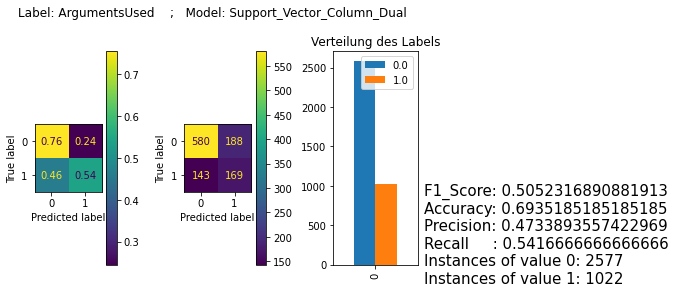

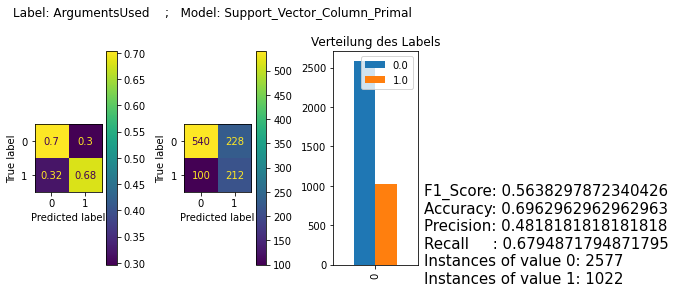

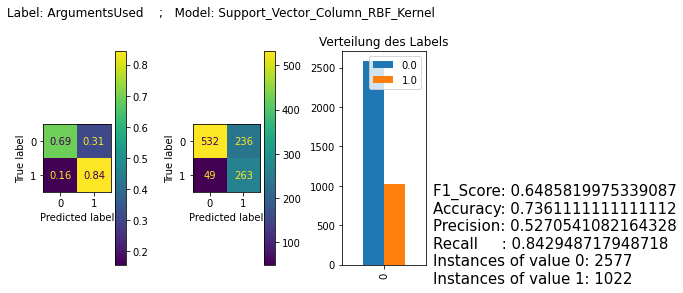

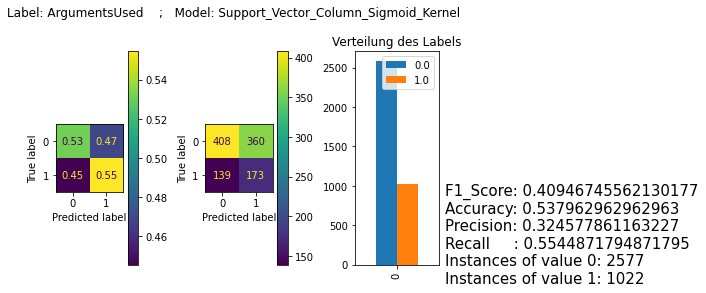

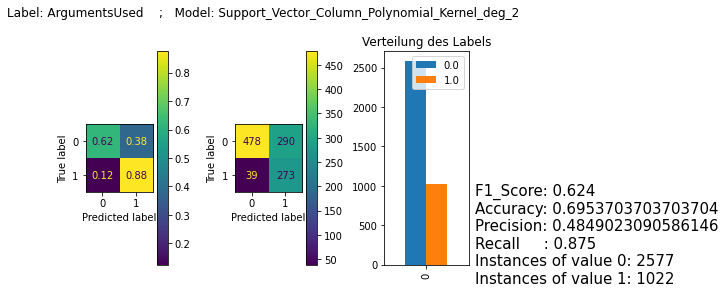

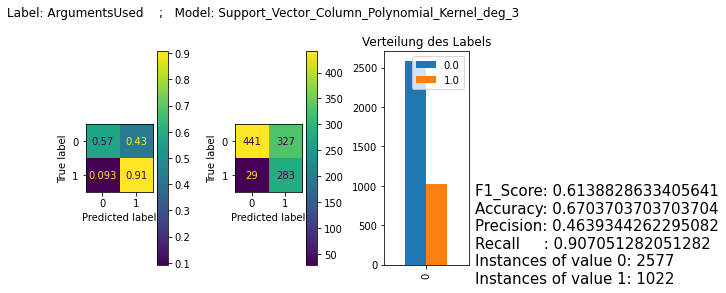

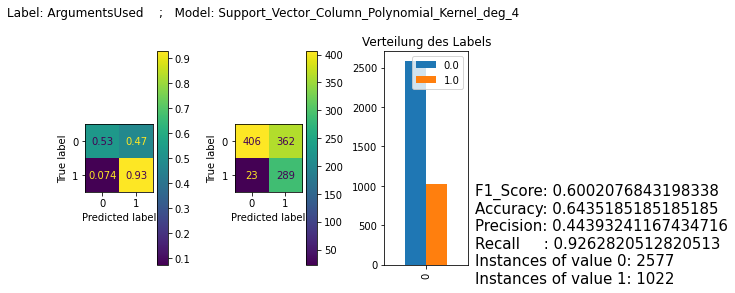

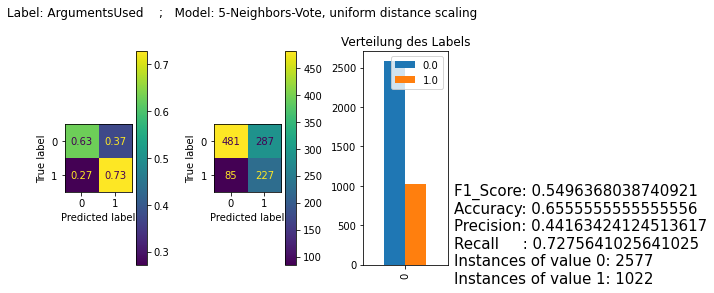

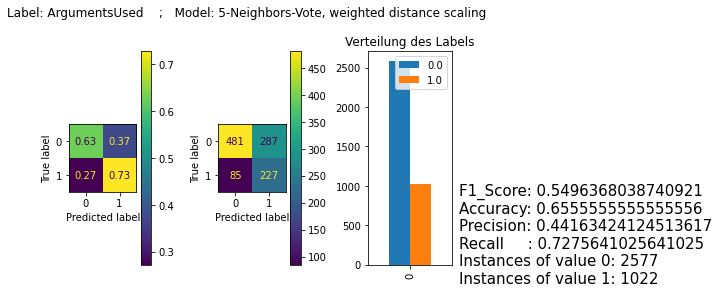

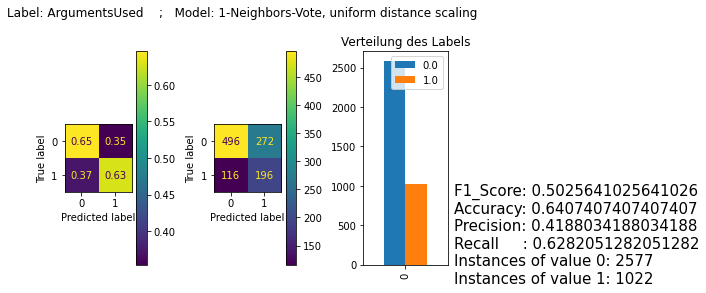

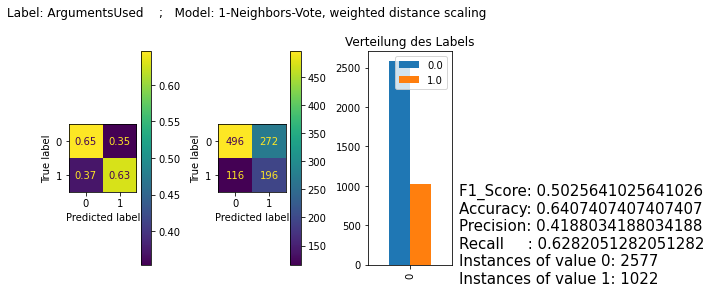

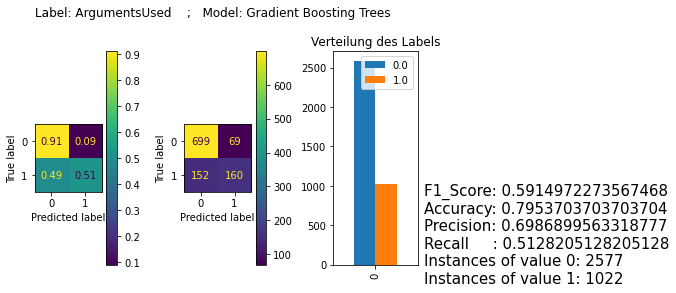

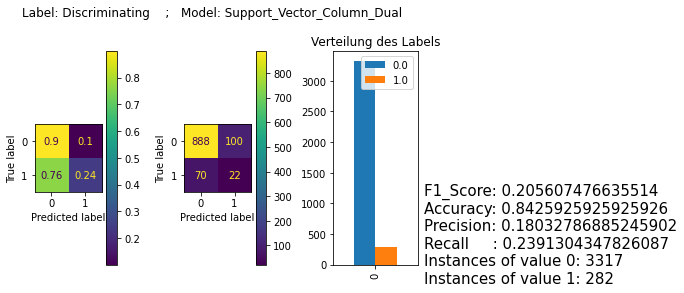

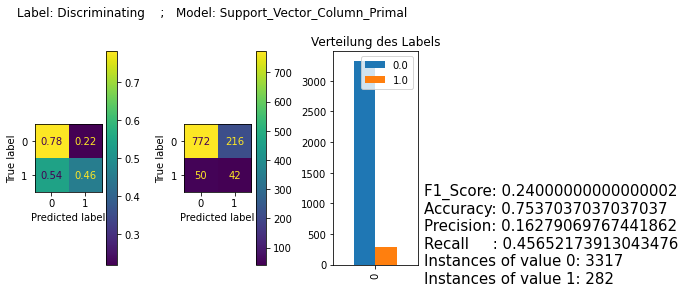

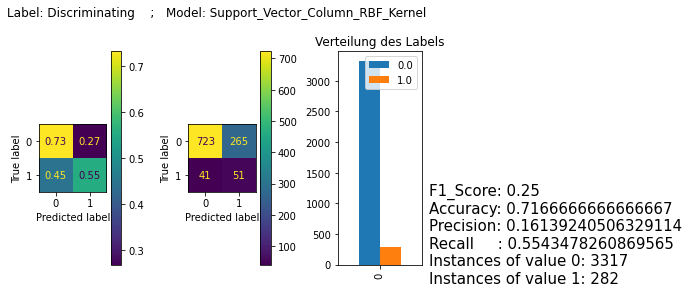

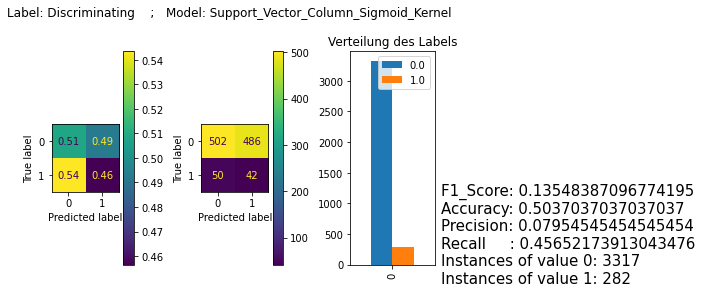

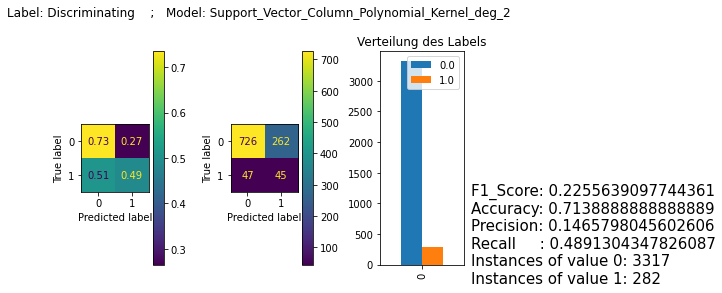

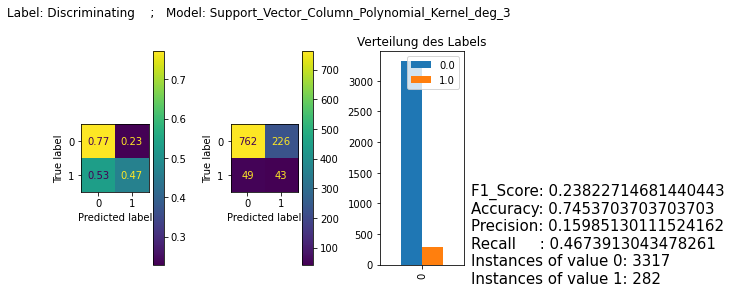

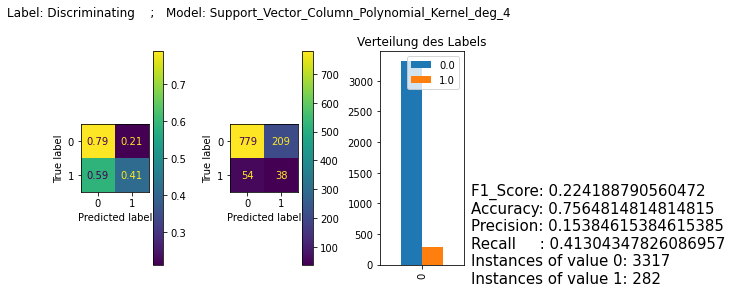

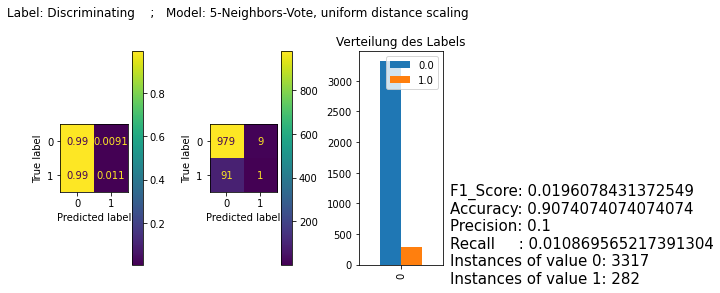

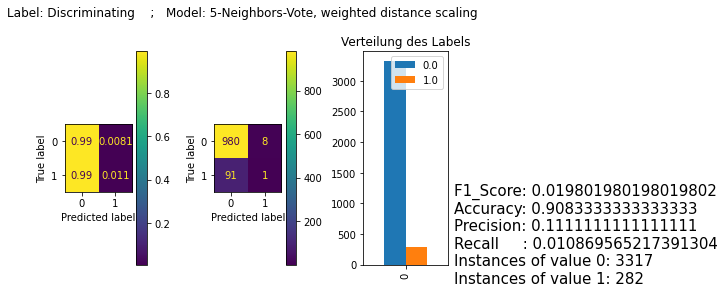

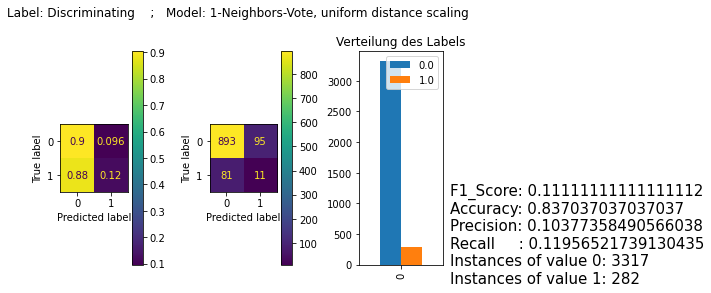

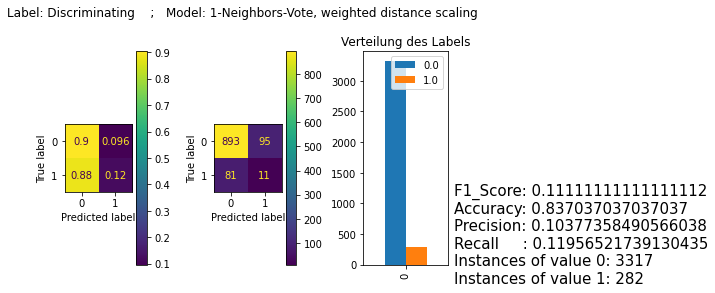

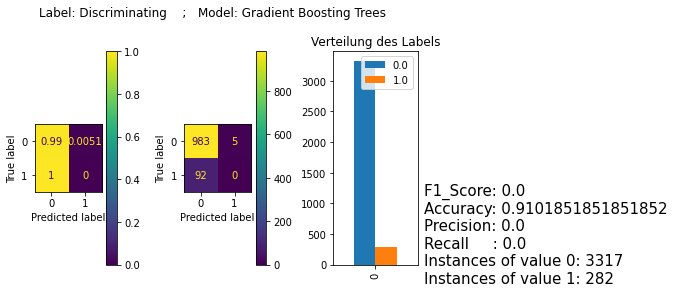

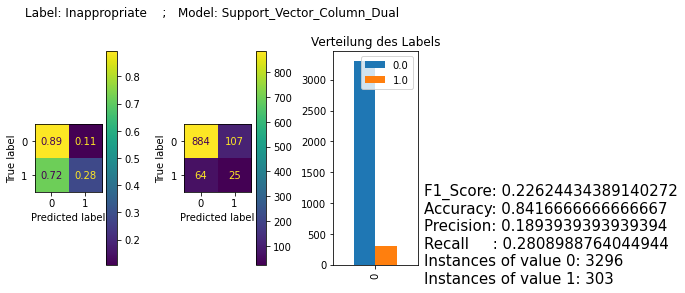

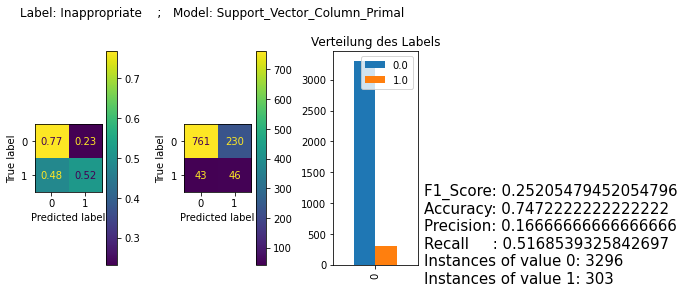

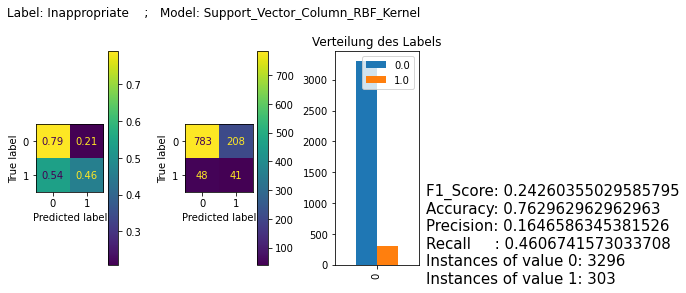

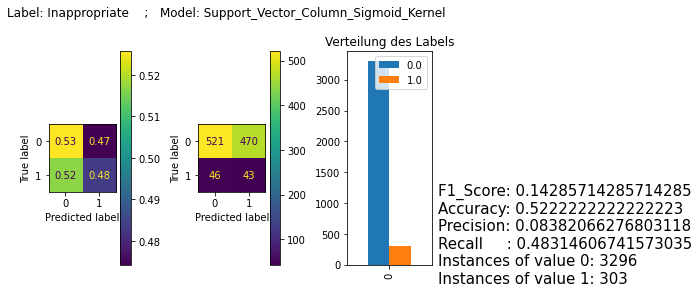

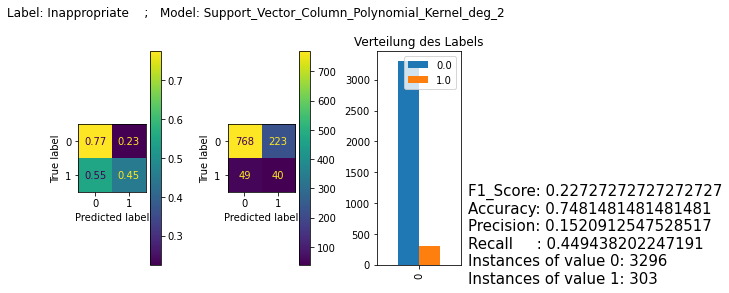

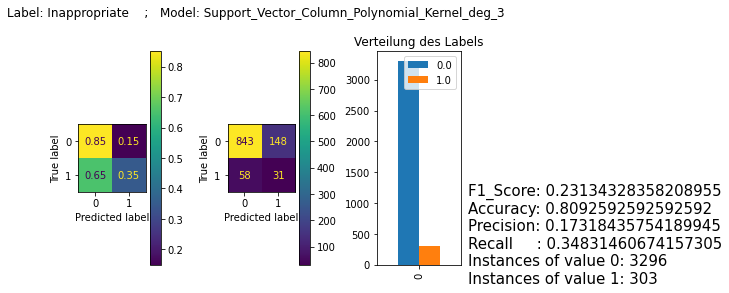

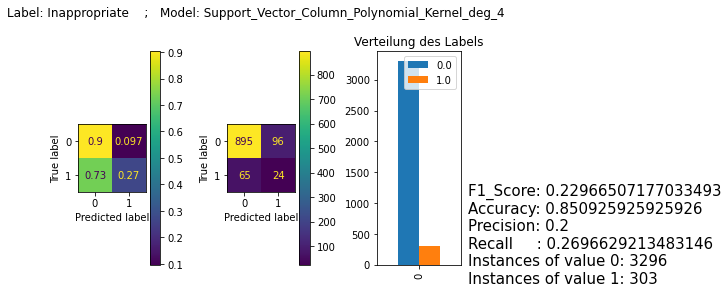

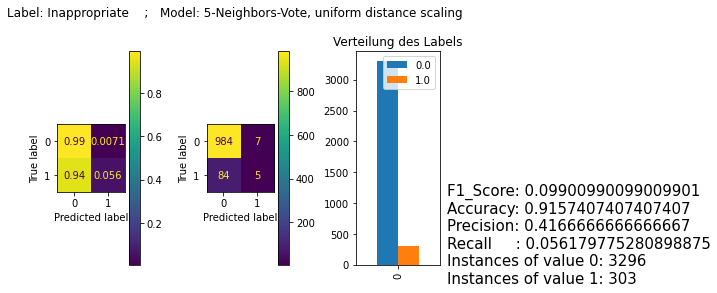

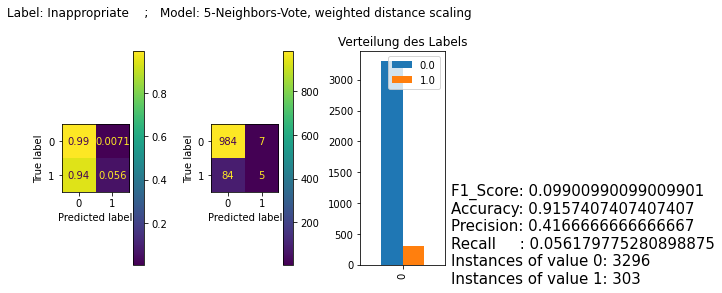

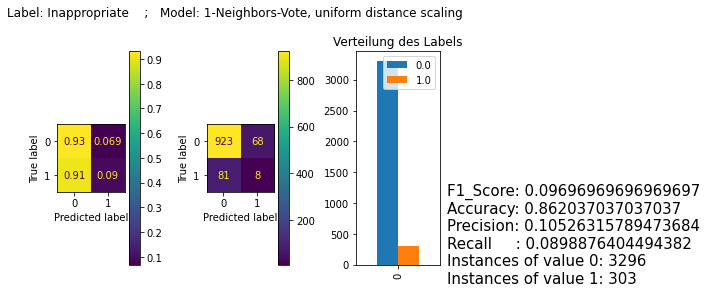

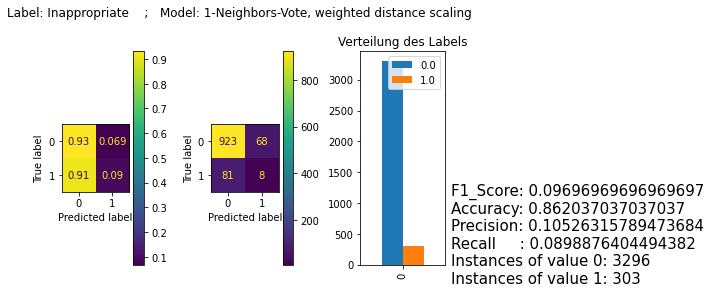

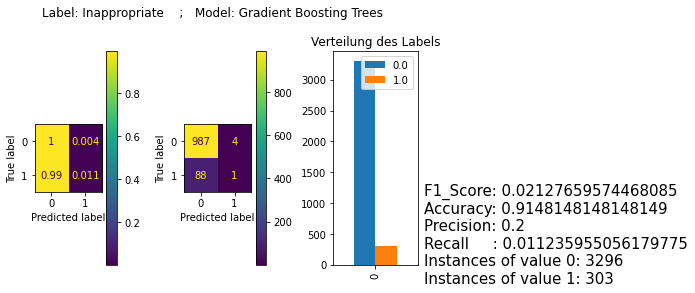

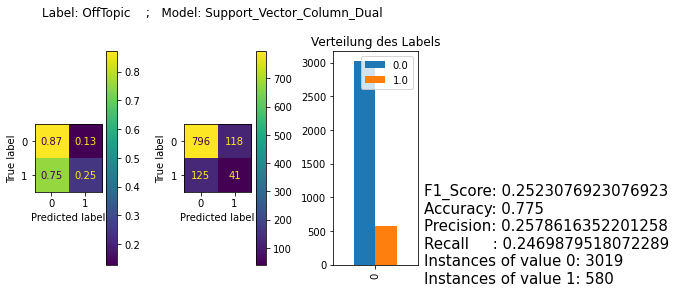

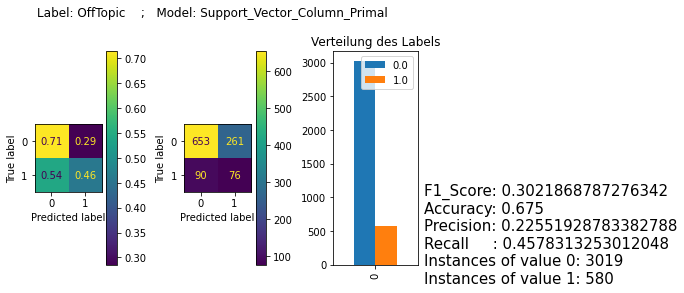

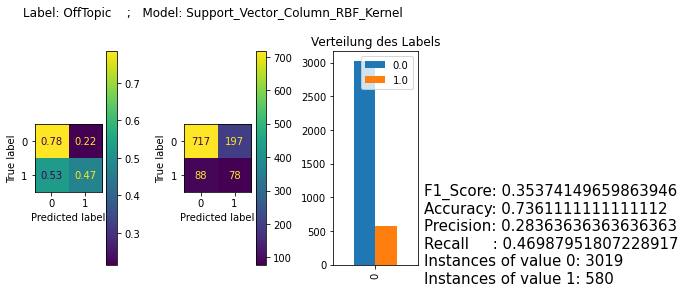

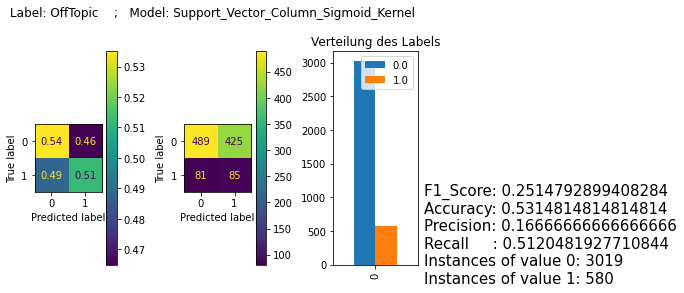

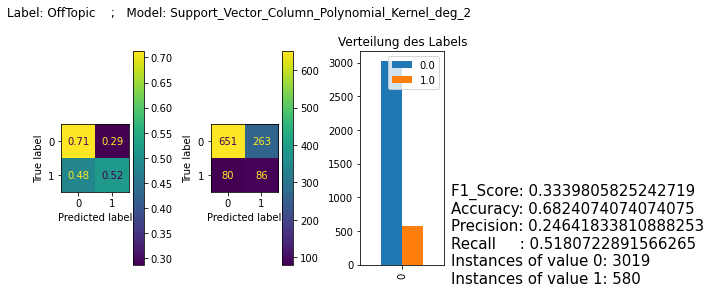

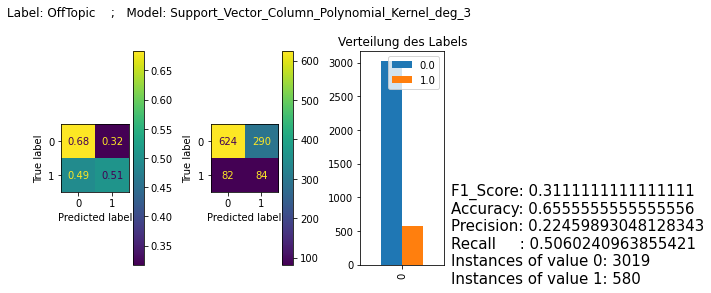

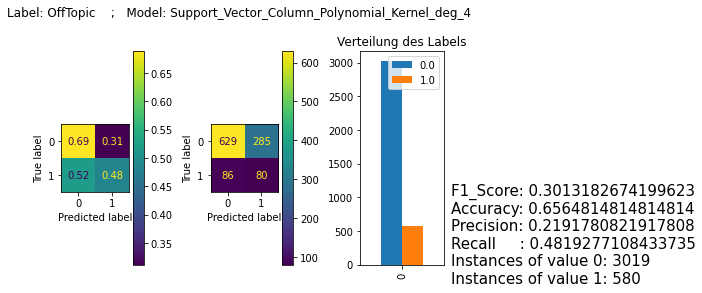

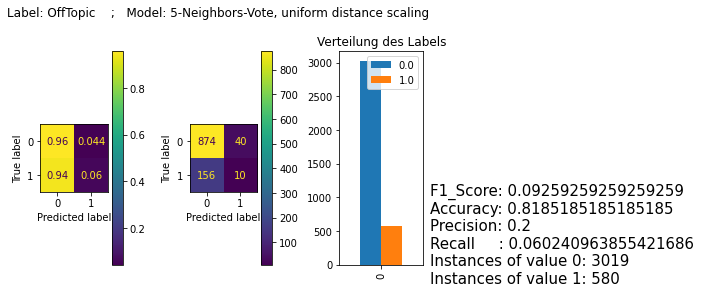

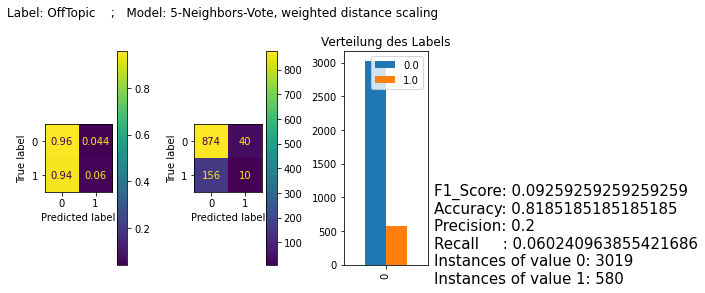

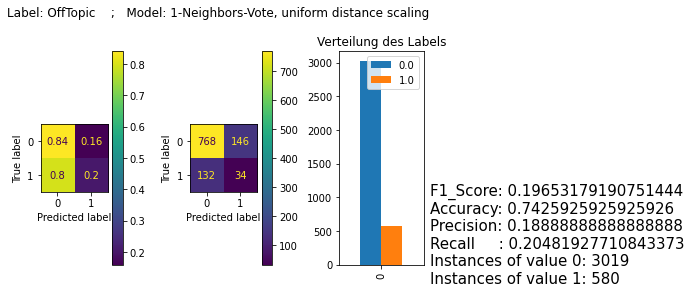

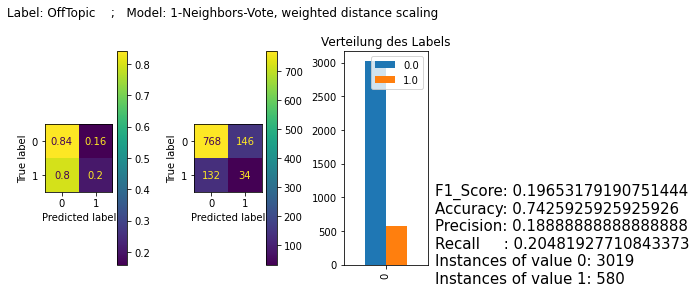

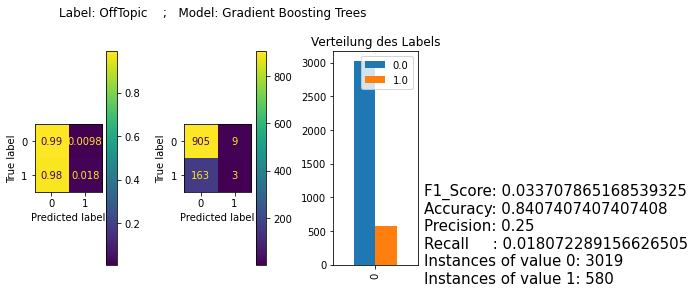

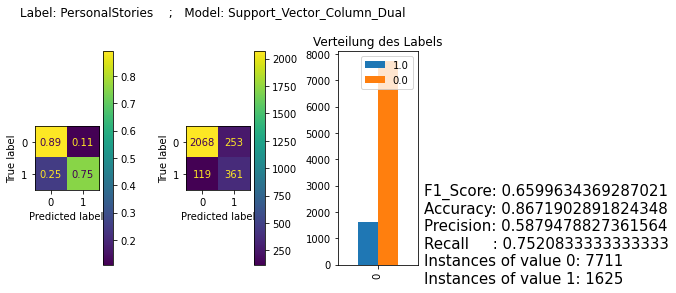

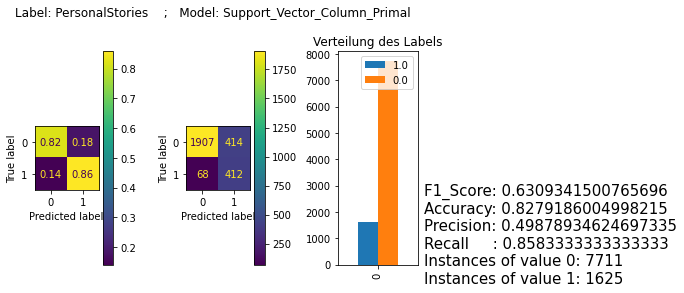

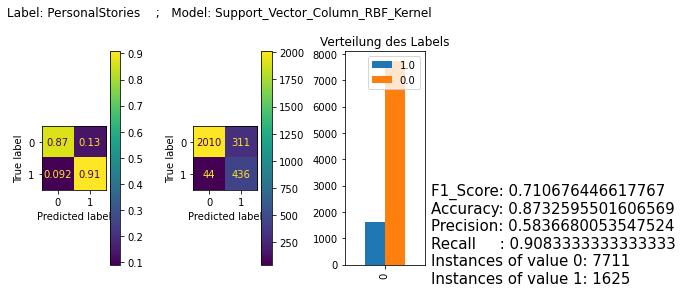

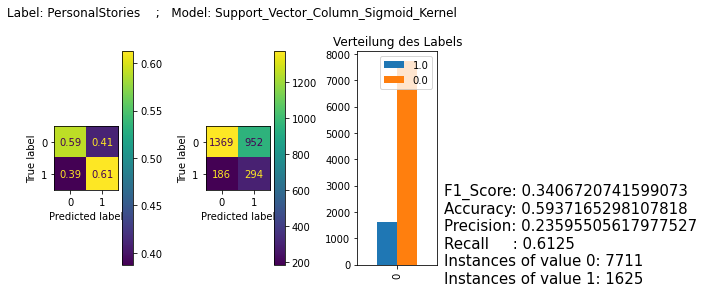

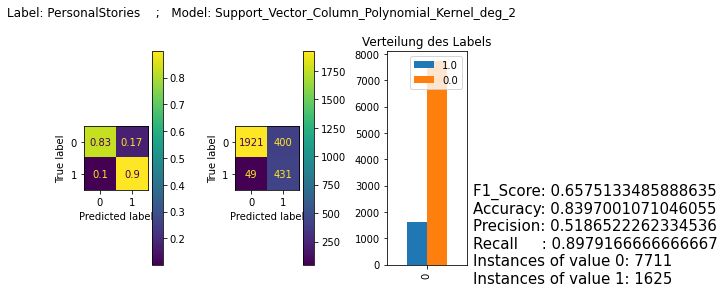

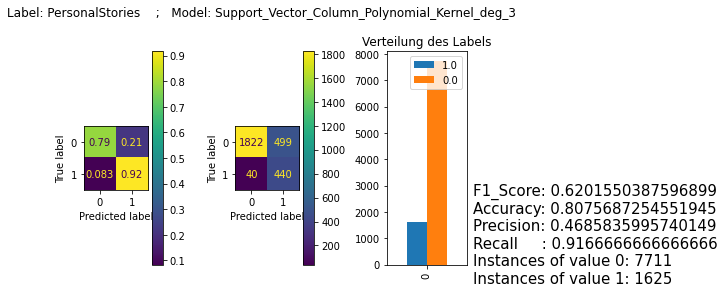

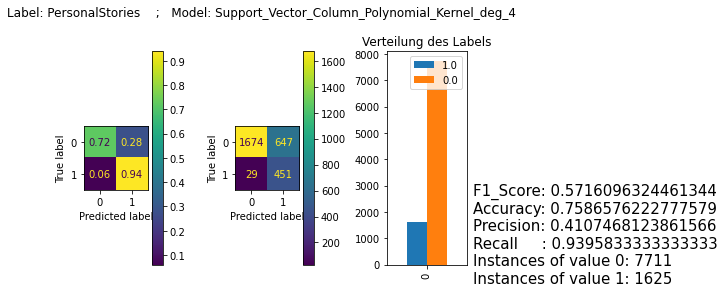

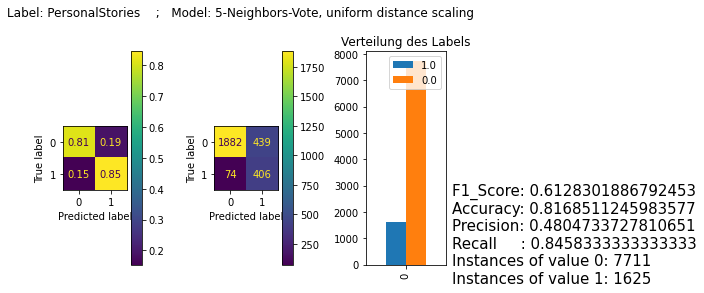

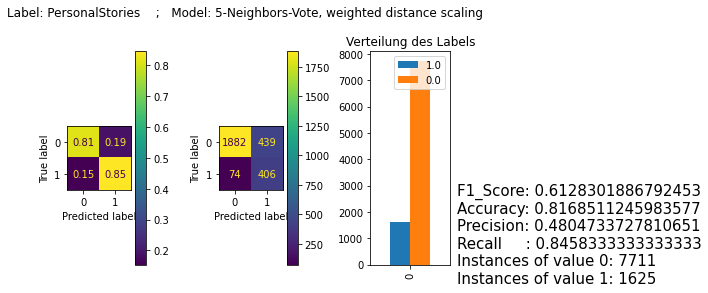

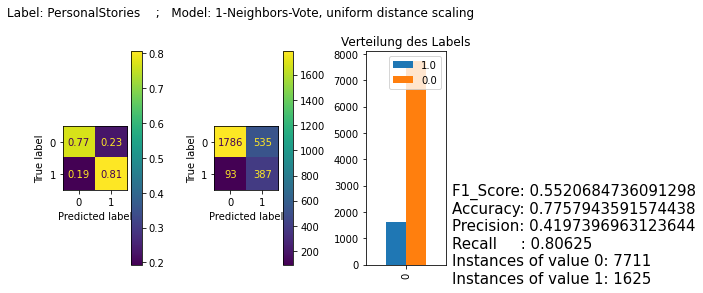

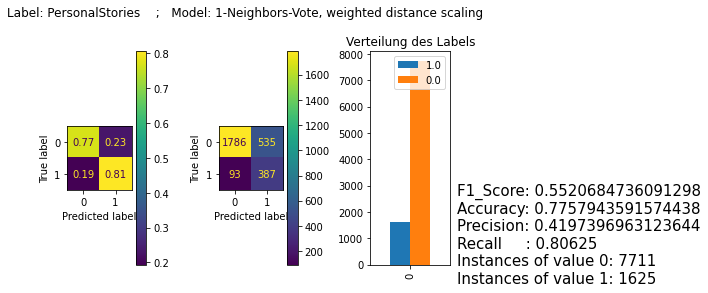

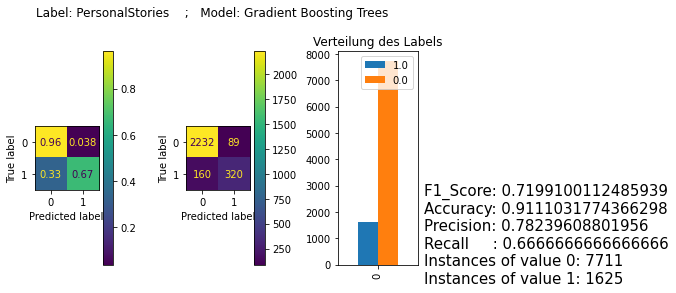

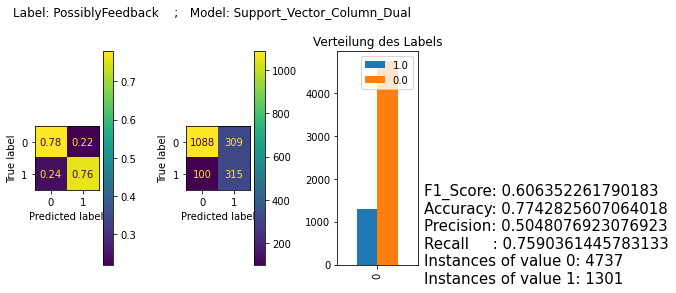

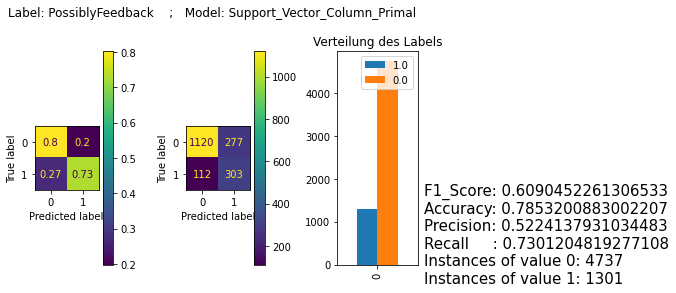

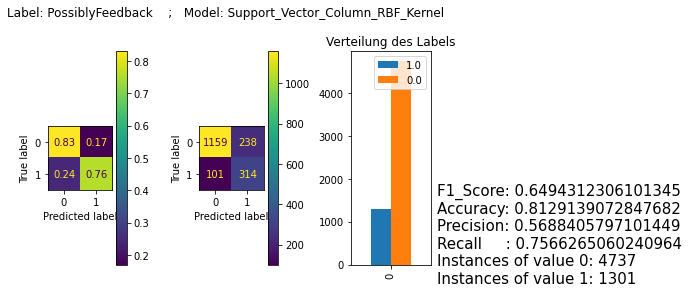

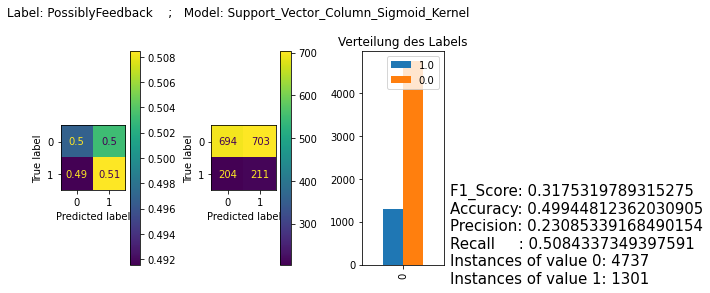

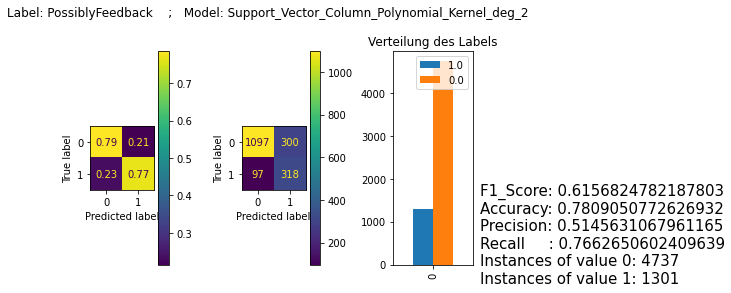

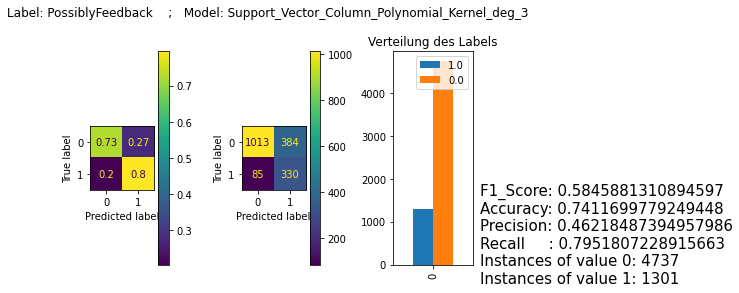

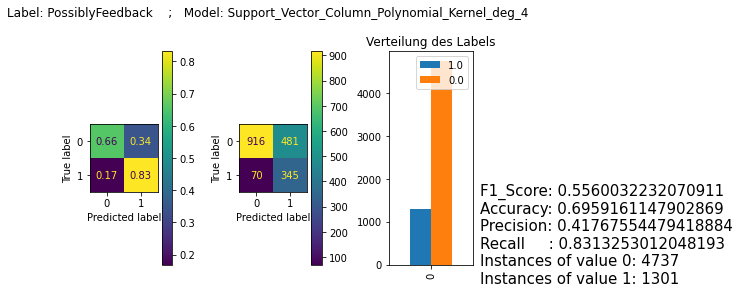

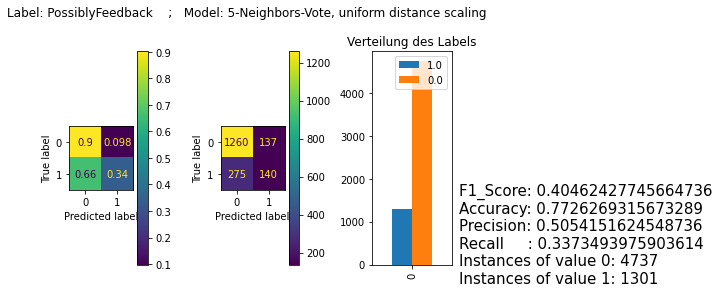

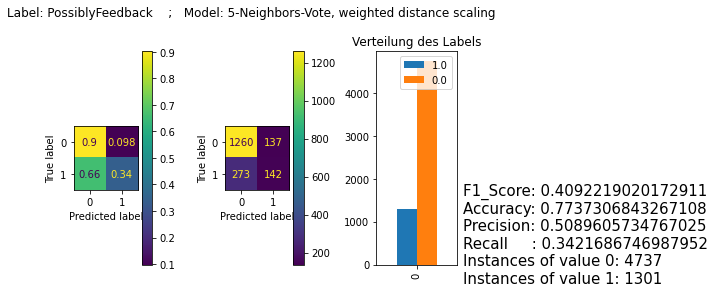

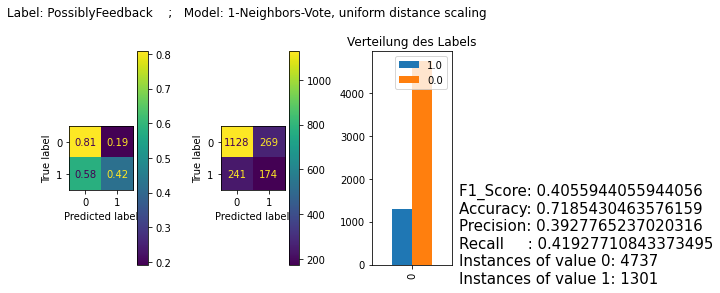

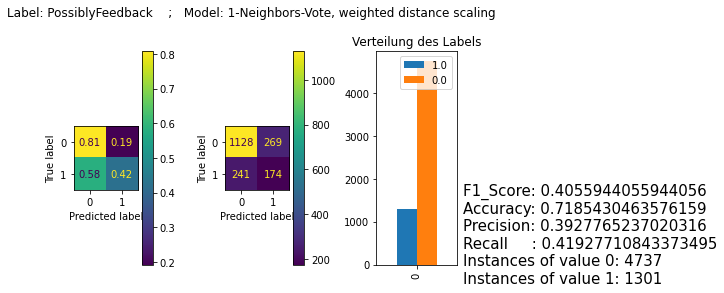

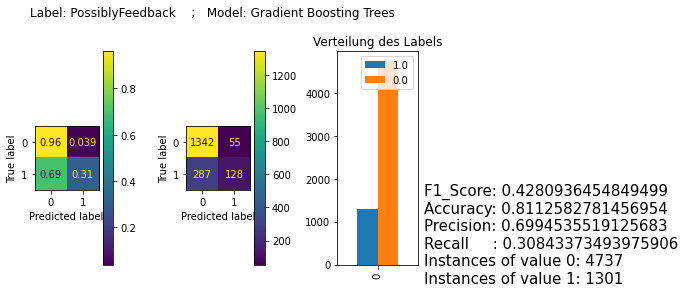

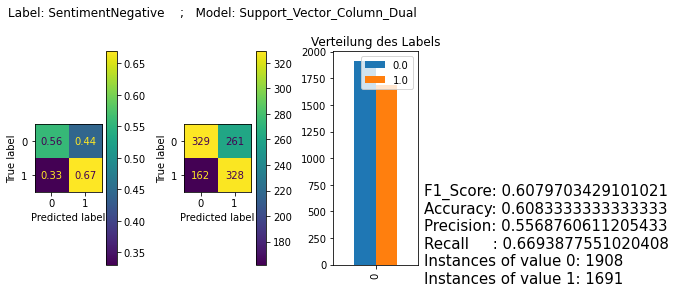

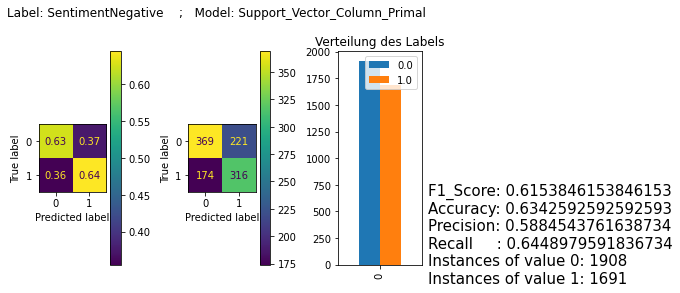

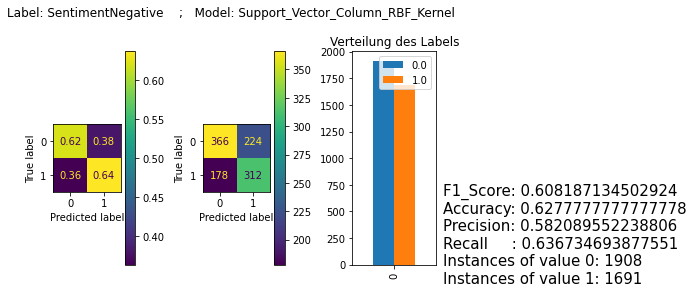

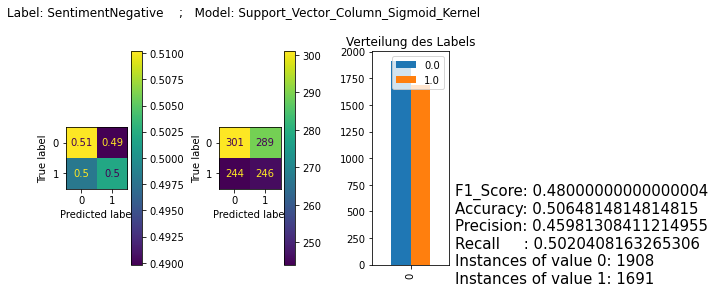

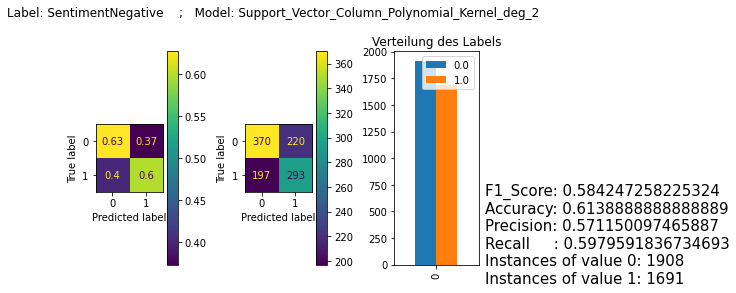

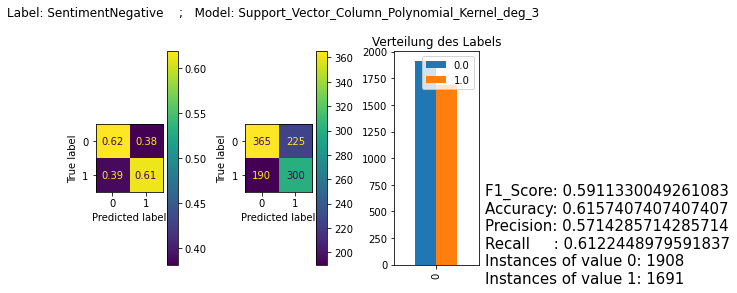

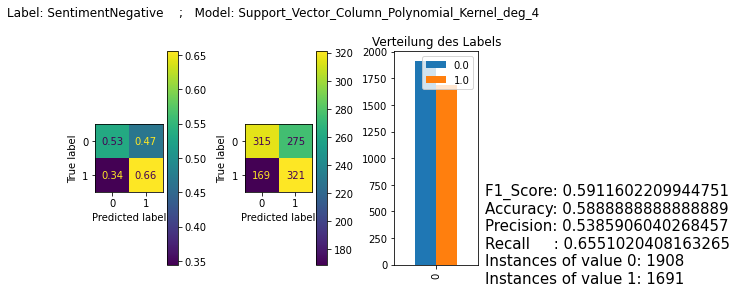

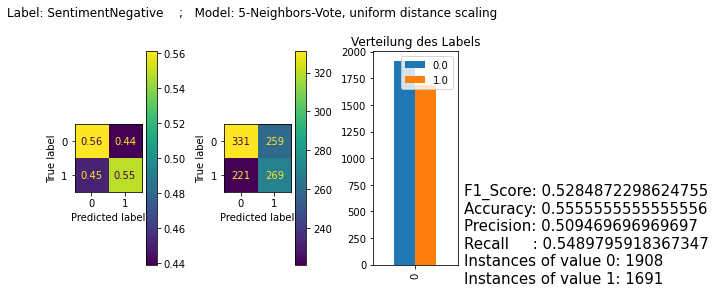

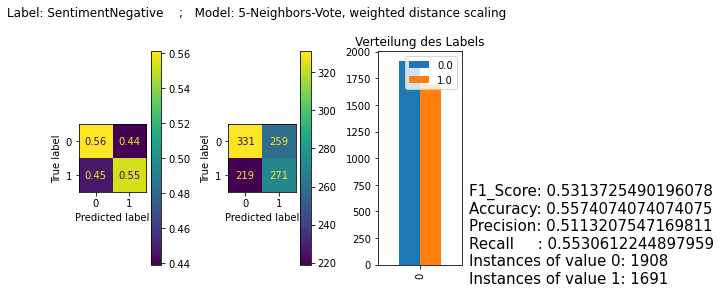

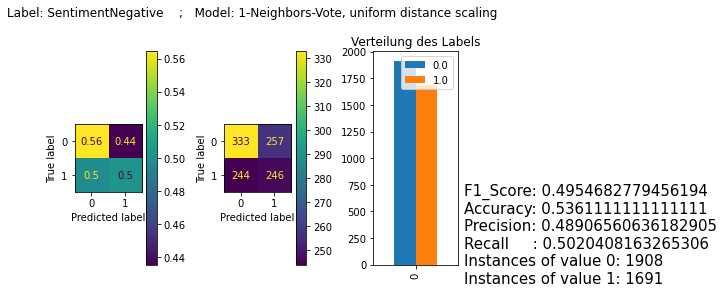

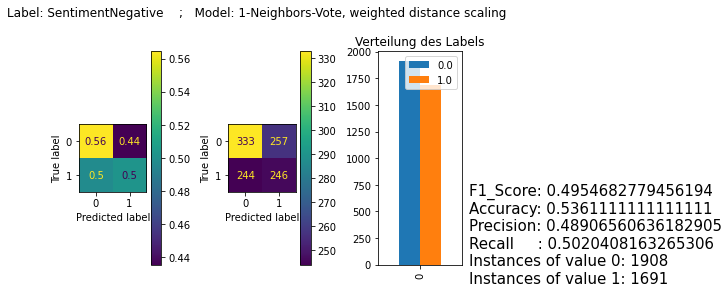

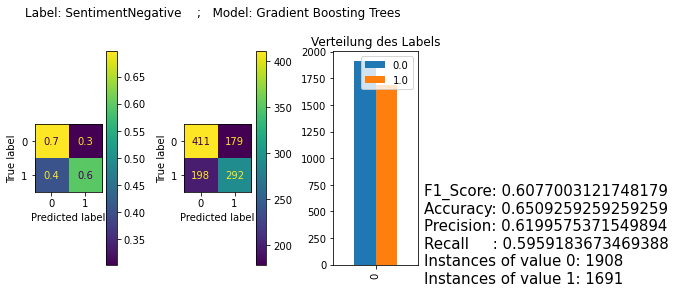

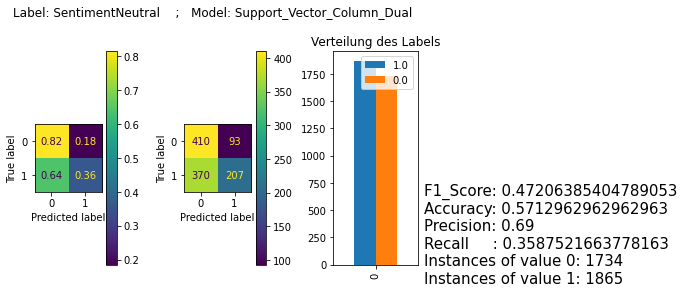

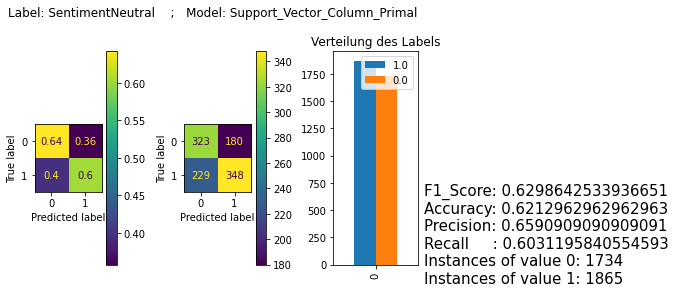

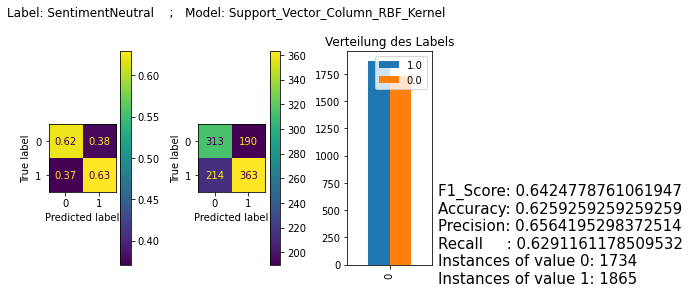

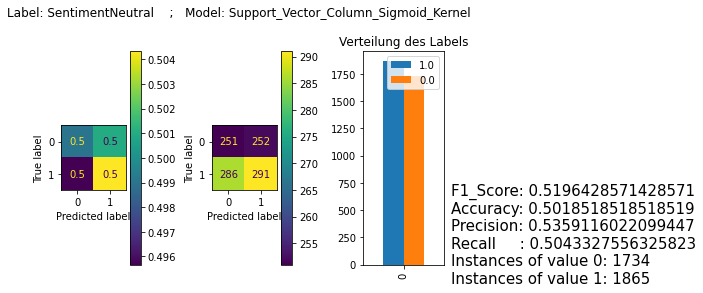

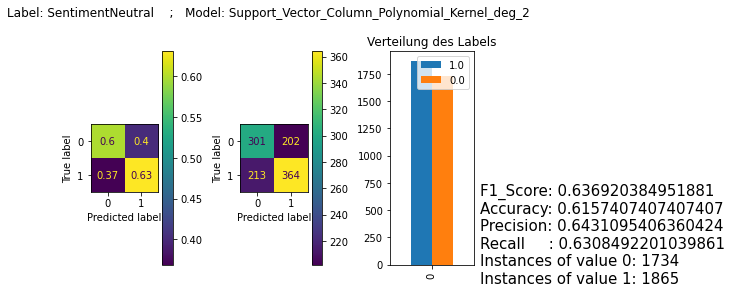

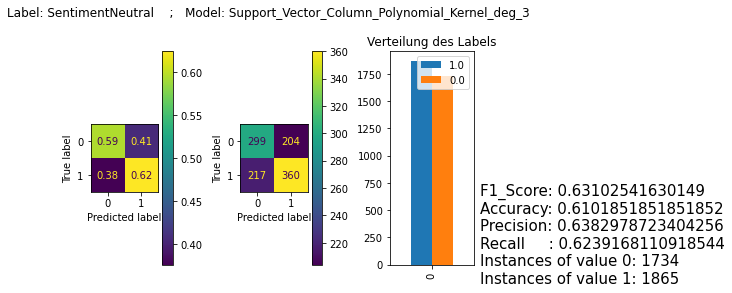

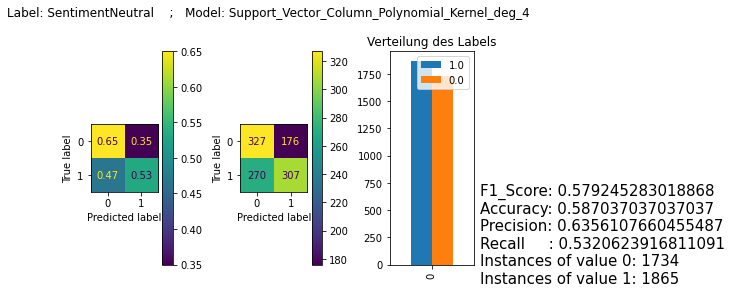

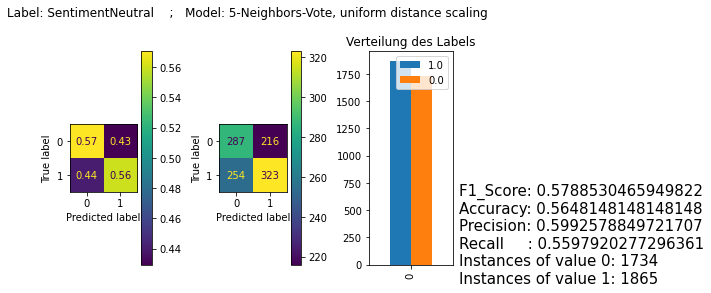

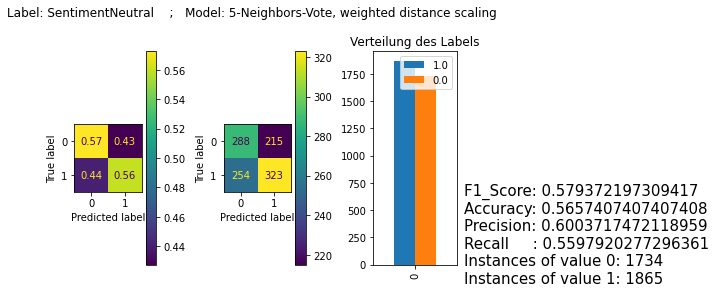

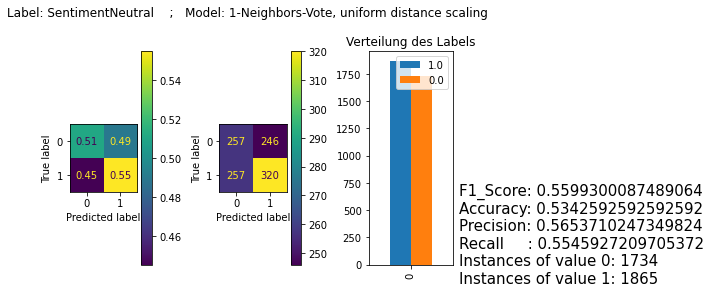

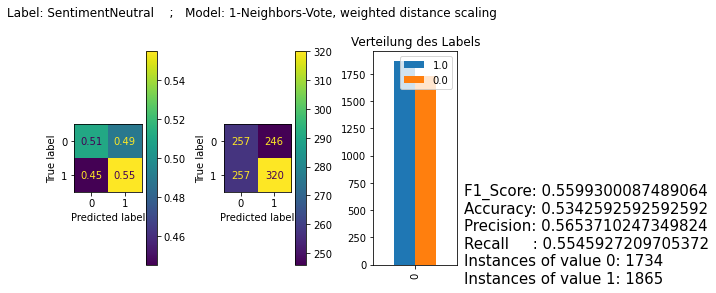

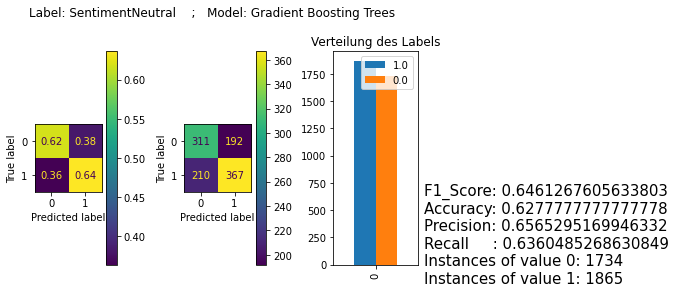

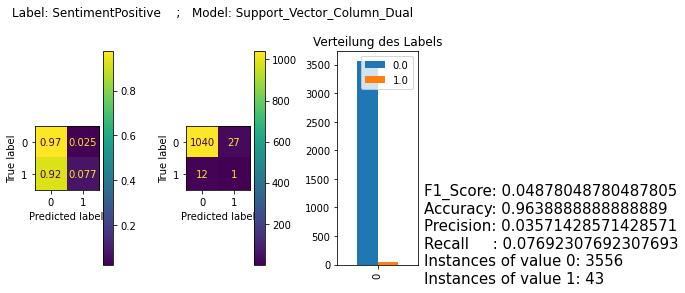

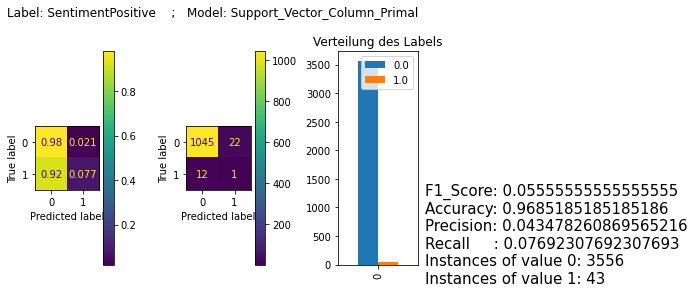

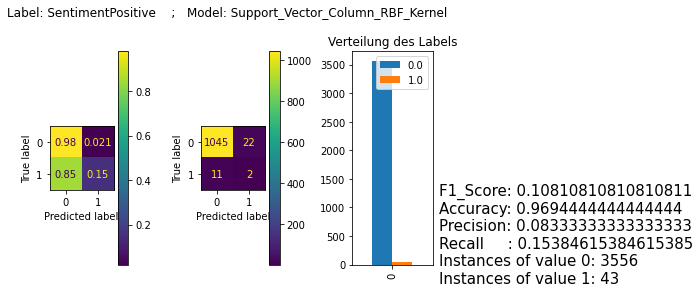

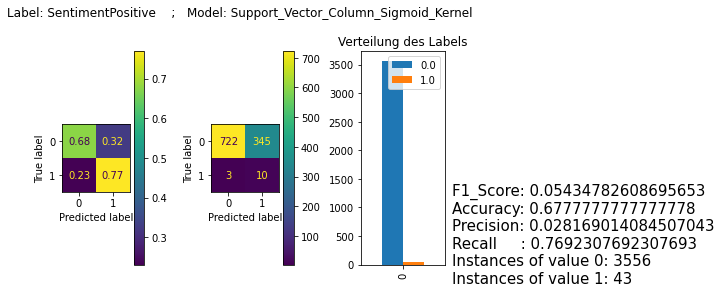

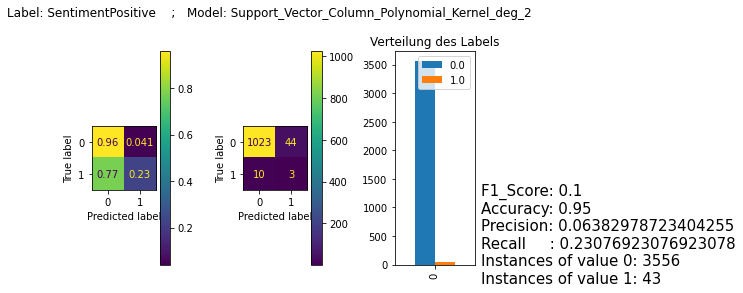

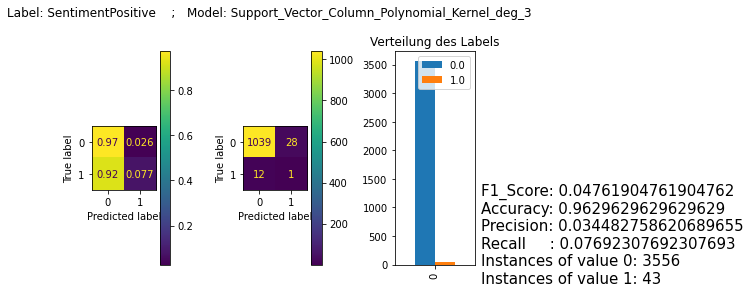

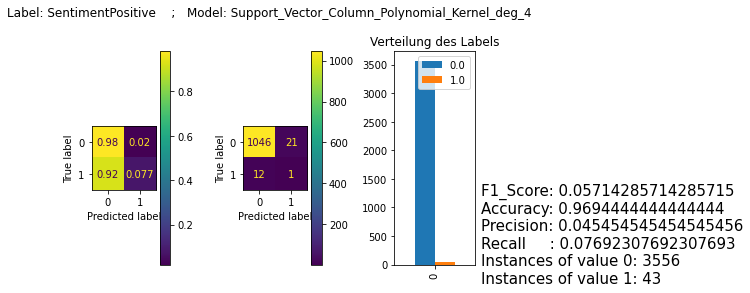

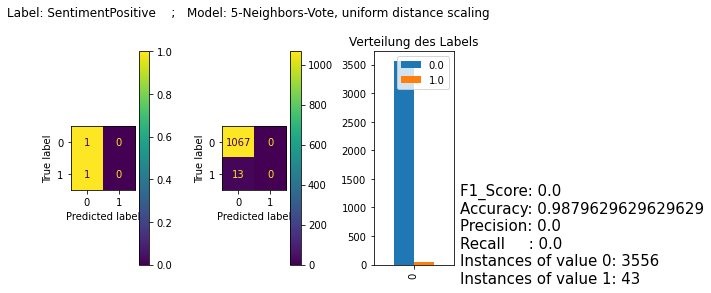

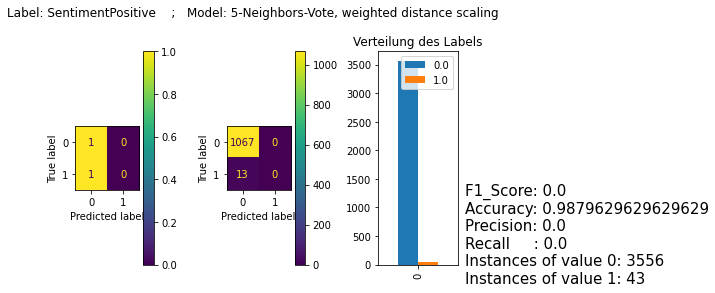

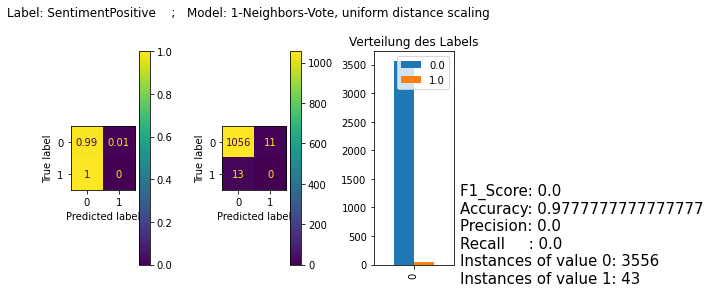

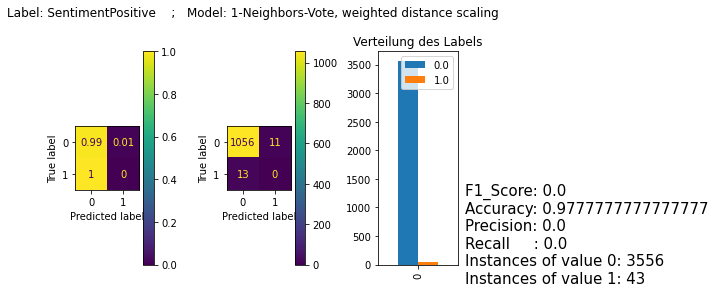

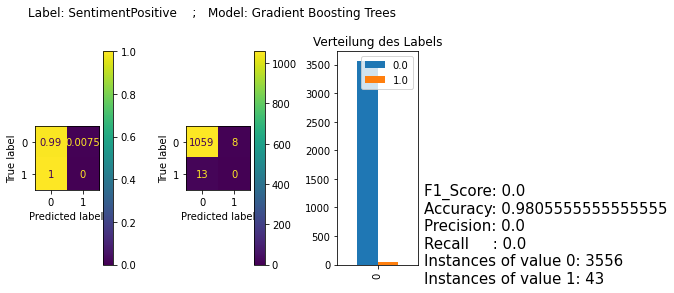

In [26]:
# Versuch 1 Erweiterung: Direktes Speichern als PDF statt als Output-Text

from matplotlib.backends.backend_pdf import PdfPages
pdf_out = PdfPages('Best_lg.pdf')
#
# Versuch 1:
# Lernen jedes Labels als binäres Label.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.
for label in labels:
    # Table_Join holen:
    joined_table = getLabeledPartPreprocessedDetailed(label)

    #Splitten in Test & Trainingsdatensätze:
    text_train, text_test, label_train, label_test = train_test_split(joined_table[:,1:],joined_table[:,0],
                                                                      test_size=0.3,
                                                                      random_state=1234, shuffle=True)
    label_test = np.array(label_test,dtype=int)
    label_train = np.array(label_train,dtype=int)
    # # Text zu Wort-Vektoren umwandeln:
    # text_train = text_train.apply(lambda x: nlp(x).vector)
    # text_test  = text_test.apply(lambda x: nlp(x).vector)
    #
    # #Handling mapping irregularities:
    # for index, element in enumerate(text_train):
    #     if (element.shape != (300,)):
    #         print(index, element.shape)
    #         text_train.iat[index]= text_train.iat[index].reshape((300,))
    #
    # for index, element in enumerate(text_test):
    #     if (element.shape != (300,)):
    #         print(index, element.shape)
    #         text_test.iat[index]= text_test.iat[index].reshape((300,))
    #
    # #Umwandeln in numpy-Matrizen:
    # text_train= np.column_stack(text_train)
    # text_test = np.column_stack(text_test)

    model_names = ["Support_Vector_Column_Dual",
                   "Support_Vector_Column_Primal",
                   "Support_Vector_Column_RBF_Kernel",
                   "Support_Vector_Column_Sigmoid_Kernel",
                   "Support_Vector_Column_Polynomial_Kernel_deg_2",
                   "Support_Vector_Column_Polynomial_Kernel_deg_3",
                   "Support_Vector_Column_Polynomial_Kernel_deg_4",
                   "5-Neighbors-Vote, uniform distance scaling",
                   "5-Neighbors-Vote, weighted distance scaling",
                   "1-Neighbors-Vote, uniform distance scaling",
                   "1-Neighbors-Vote, weighted distance scaling",
                   "Gradient Boosting Trees"]
    models = [svm.LinearSVC(class_weight = "balanced"),
              svm.LinearSVC(dual= False,class_weight = "balanced"),
              svm.SVC(class_weight = "balanced"),
              svm.SVC(kernel="sigmoid",class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=2,class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=3,class_weight = "balanced"),
              svm.SVC(kernel="poly",degree=4,class_weight = "balanced"),
              KNeighborsClassifier(weights = "uniform"),
              KNeighborsClassifier(weights = "distance"),
              KNeighborsClassifier(weights = "uniform",n_neighbors=1),
              KNeighborsClassifier(weights = "distance",n_neighbors=1),
              GradientBoostingClassifier()]
    # model_names = ["Support_Vector_Column", "Naive Gaussian Bayes", "Multi_Layer_Perceptron"]
    # models = [svm.LinearSVC(),naive_bayes.GaussianNB(), MLPClassifier()]
    previous_score = 0
    current_score =0
    best_fig = None
    for model,model_name in zip(models,model_names):
        # Transposed the matrices in the input because calculating text_train takes so long, and I didn't want to recalculate it.

        #Trainieren des Modells:
        model.fit(text_train,label_train)

        #Vom trainierten Modell geschätzte Labels des Testdatensatzes:
        model_predictions = model.predict(text_test)

        # Verteilung der Instanzen auf das Label (d.h. wie viele 0-Instanzen und wie viele 1-Instanzen gibt es)
        counts_dict = Counter(joined_table[:,0])
        val_counts = pd.DataFrame({x:[counts_dict[x]] for x in (counts_dict)})

        print("--------------")
        print("--------------")
        print("Label:    {}".format(label))
        print("{}:".format(model_name))


        fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
        fig.suptitle(("Label: {}    ;   Model: {}".format(label,model_name)))
        classifier_evaluation = ("F1_Score: "+  str(sklearn.metrics.f1_score       (label_test, model_predictions))+ "\n"+
                                 "Accuracy: "+  str(sklearn.metrics.accuracy_score (label_test, model_predictions))+ "\n"+
                                 "Precision: "+ str(sklearn.metrics.precision_score(label_test, model_predictions))+ "\n"+
                                 "Recall     : "+    str(sklearn.metrics.recall_score   (label_test, model_predictions))+ "\n"+
                                 "Instances of value 0: "+str(int(val_counts[0])) +"\n"+ "Instances of value 1: "+str(int(val_counts[1])))
        # ax1.annotate( classifier_evaluation, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize = 18)
        #Alternative Variante
        plt.figtext(0.99, 0.01, classifier_evaluation, horizontalalignment='left', verticalalignment ="bottom", fontsize = 15)
        conf_matrix_normalized = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions, normalize="true",ax= ax1)
        conf_matrix = ConfusionMatrixDisplay.from_predictions(label_test,model_predictions,ax= ax2)
        bar_plot = val_counts.plot.bar(ax = ax3,title = "Verteilung des Labels")
        fig.tight_layout()

        current_score =sklearn.metrics.f1_score(label_test, model_predictions)
        if current_score>previous_score:
            best_fig = fig
            previous_score = current_score
    pdf_out.savefig(best_fig,bbox_inches='tight')




pdf_out.close()



In [ ]:
# Versuch 3: ON_HOLD - Es gibt zu wenig positive Ausprägungen...
# Die Labels "SentimentNegative","SentimentNeutral" und "SentimentPositive" können als Ausprägungen eines einzelnen Labels interpretiert werden.
# Zu beachten ist hierbei allerdings, dass einige Posts mehrere dieser Labels gleichzeitig haben.
# Wir können also einen Regressor bauen für den 0 - Negativ, 1 - Neutral, 2 - Positiv bedeutet.
# Pro Label testen wir drei Ansätze: SVM, Naive_Bayes, und Multi-Layer-Perceptron.

